# APS360 Project: Baseline

### Part A. Data Loading

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
from PIL import Image
import shutil
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.multiprocessing as mp
from tqdm import tqdm

mp.set_start_method('spawn', force=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 32
LEARNING_RATE = 0.0002
LAMBDA_IDENTITY = 0.0  # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 1
NUM_EPOCHS = 50
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_ANIME = "models/gen_anime"
CHECKPOINT_GENERATOR_HUMAN = "models/gen_human"
CHECKPOINT_DISCRIMINATOR_ANIME = "models/disc_anime"
CHECKPOINT_DISCRIMINATOR_HUMAN = "models/disc_human"

#### 0. Helper Functions

In [2]:
###############################################################################
# Data Loading
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler


class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Since there are no labels, we can return a dummy label (0)

def create_subset_dataset(original_dir, subset_dir, subset_size=100):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    image_paths = [os.path.join(original_dir, fname) for fname in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, fname))]
    
    np.random.seed(1000)
    np.random.shuffle(image_paths)
    subset_paths = image_paths[:subset_size]
    
    for img_path in subset_paths:
        shutil.copy(img_path, subset_dir)

    print(f"Subset created with {len(subset_paths)} images in {subset_dir}")

def get_data_loader(data_dir, batch_size, image_size=(128, 128), subset_size=None):

    transform = transforms.Compose([
        transforms.Resize(image_size),
        #transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    dataset = CustomImageDataset(root_dir=data_dir, transform=transform)

    if subset_size:
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)
        subset_indices = indices[:subset_size]
        subset_sampler = SubsetRandomSampler(subset_indices)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler)
        return loader

    def split_indices(dataset):
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)

        train_split = int(0.7 * num_images)
        val_split = int(0.15 * num_images)

        train_indices = indices[:train_split]
        val_indices = indices[train_split:train_split + val_split]
        test_indices = indices[train_split + val_split:]

        return train_indices, val_indices, test_indices

    train_indices, val_indices, test_indices = split_indices(dataset)

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader

def verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B):
    # Verify the split sizes for dataset A
    total_examples_A = len(train_loader_A.sampler) + len(val_loader_A.sampler) + len(test_loader_A.sampler)
    train_size_A = len(train_loader_A.sampler)
    val_size_A = len(val_loader_A.sampler)
    test_size_A = len(test_loader_A.sampler)

    train_proportion_A = train_size_A / total_examples_A
    val_proportion_A = val_size_A / total_examples_A 
    test_proportion_A = test_size_A / total_examples_A

    print(f"Dataset A - Total examples: {total_examples_A}")
    print(f"Dataset A - Train examples: {train_size_A} ({train_proportion_A:.2%})")
    print(f"Dataset A - Validation examples: {val_size_A} ({val_proportion_A:.2%})")
    print(f"Dataset A - Test examples: {test_size_A} ({test_proportion_A:.2%})")

    # Verify the split sizes for dataset B
    total_examples_B = len(train_loader_B.sampler) + len(val_loader_B.sampler) + len(test_loader_B.sampler)
    train_size_B = len(train_loader_B.sampler)
    val_size_B = len(val_loader_B.sampler)
    test_size_B = len(test_loader_B.sampler)

    train_proportion_B = train_size_B / total_examples_B
    val_proportion_B = val_size_B / total_examples_B 
    test_proportion_B = test_size_B / total_examples_B

    print(f"Dataset B - Total examples: {total_examples_B}")
    print(f"Dataset B - Train examples: {train_size_B} ({train_proportion_B:.2%})")
    print(f"Dataset B - Validation examples: {val_size_B} ({val_proportion_B:.2%})")
    print(f"Dataset B - Test examples: {test_size_B} ({test_proportion_B:.2%})")

    # Check for overlaps in dataset A
    train_indices_A = list(train_loader_A.sampler.indices)
    val_indices_A = list(val_loader_A.sampler.indices)
    test_indices_A = list(test_loader_A.sampler.indices)
    print("Checking overlaps for dataset A...")
    check_for_overlaps(train_indices_A, val_indices_A, test_indices_A)

    # Check for overlaps in dataset B
    train_indices_B = list(train_loader_B.sampler.indices)
    val_indices_B = list(val_loader_B.sampler.indices)
    test_indices_B = list(test_loader_B.sampler.indices)
    print("Checking overlaps for dataset B...")
    check_for_overlaps(train_indices_B, val_indices_B, test_indices_B)

def check_for_overlaps(train_indices, val_indices, test_indices):
    # Convert indices to sets
    train_indices_set = set(train_indices)
    val_indices_set = set(val_indices)
    test_indices_set = set(test_indices)

    # Check for overlaps
    train_val_overlap = train_indices_set.intersection(val_indices_set)
    train_test_overlap = train_indices_set.intersection(test_indices_set)
    val_test_overlap = val_indices_set.intersection(test_indices_set)

    # Print the results
    print(f"Train/Validation Overlap: {len(train_val_overlap)} indices")
    print(f"Train/Test Overlap: {len(train_test_overlap)} indices")
    print(f"Validation/Test Overlap: {len(val_test_overlap)} indices")

    if not train_val_overlap and not train_test_overlap and not val_test_overlap:
        print("No overlaps found between train, validation, and test sets.")
    else:
        print("Overlaps detected. Please check the data splitting logic.")

###############################################################################
# Training
import glob

def evaluate(generator, discriminator, loader, criterion, device):
    generator.eval()
    discriminator.eval()
    
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            
            # Generate fake images
            fake_images = generator(inputs)
            outputs = discriminator(fake_images)
            
            # Calculate loss
            loss = criterion(outputs, torch.ones_like(outputs).to(device))
            total_loss += loss.item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"=> Saving checkpoint to {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_latest_checkpoint(model, optimizer, checkpoint_prefix, lr, batch_size):
    checkpoint_files = glob.glob(f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_*.pth.tar")
    if not checkpoint_files:
        print(f"=> No checkpoint found for {checkpoint_prefix}. Starting from scratch.")
        return 0

    # Extract the latest epoch number from the checkpoint file names
    latest_epoch = max([int(file.split('_')[-1].split('.')[0]) for file in checkpoint_files])
    checkpoint_file = f"{checkpoint_prefix}_lr{lr}_bs{batch_size}_epoch_{latest_epoch}.pth.tar"

    print(f"=> Loading checkpoint {checkpoint_file}")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    return latest_epoch + 1

def get_model_name(model_type, epoch, learning_rate, batch_size):
    return f"models/{model_type}_lr{learning_rate}_bs{batch_size}_epoch_{epoch}.pth.tar"

def list_checkpoints(checkpoint_prefix):
    checkpoint_pattern = os.path.join(f"{checkpoint_prefix}_epoch_*.pth.tar")
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if not checkpoint_files:
        print(f"No checkpoint found for prefix: {checkpoint_prefix}")
    else:
        print(f"Checkpoints found for prefix {checkpoint_prefix}:")
        for checkpoint in checkpoint_files:
            print(checkpoint)
            
def save_losses(train_loss_anime_history, train_loss_human_history, val_loss_anime_history, val_loss_human_history, path_prefix):
    np.savetxt(f"{path_prefix}_train_loss_anime.csv", train_loss_anime_history)
    np.savetxt(f"{path_prefix}_train_loss_human.csv", train_loss_human_history)
    np.savetxt(f"{path_prefix}_val_loss_anime.csv", val_loss_anime_history)
    np.savetxt(f"{path_prefix}_val_loss_human.csv", val_loss_human_history)


###############################################################################
# Training Curve
def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_loss_anime_file = f"{path}_train_loss_anime.csv"
    train_loss_human_file = f"{path}_train_loss_human.csv"
    val_loss_anime_file = f"{path}_val_loss_anime.csv"
    val_loss_human_file = f"{path}_val_loss_human.csv"

    train_loss_anime = np.loadtxt(train_loss_anime_file)
    train_loss_human = np.loadtxt(train_loss_human_file)
    val_loss_anime = np.loadtxt(val_loss_anime_file)
    val_loss_human = np.loadtxt(val_loss_human_file)

    plt.figure()
    plt.title("Train vs Validation Loss (Anime)")
    n = len(train_loss_anime)  # number of epochs
    plt.plot(range(1, n + 1), train_loss_anime, label="Train Anime")
    plt.plot(range(1, n + 1), val_loss_anime, label="Validation Anime")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.figure()
    plt.title("Train vs Validation Loss (Human)")
    plt.plot(range(1, n + 1), train_loss_human, label="Train Human")
    plt.plot(range(1, n + 1), val_loss_human, label="Validation Human")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    

### 1. Data Loading and Splitting

#### 1.1 Load Data

In [3]:
# Use smaller subsets for quick testing
create_subset_dataset('/root/aps360-project/data/dataSetA_10k', 'data/subset_dataSetA', subset_size=5000)
create_subset_dataset('/root/aps360-project/data/dataSetB_10k', 'data/subset_dataSetB', subset_size=5000)

# Load data from the subsets
train_loader_A, val_loader_A, test_loader_A = get_data_loader('/root/aps360-project/baseline/data/subset_dataSetA', BATCH_SIZE, image_size=(128, 128))
train_loader_B, val_loader_B, test_loader_B = get_data_loader('/root/aps360-project/baseline/data/subset_dataSetB', BATCH_SIZE, image_size=(128, 128))

Subset created with 5000 images in data/subset_dataSetA
Subset created with 5000 images in data/subset_dataSetB


In [4]:
# Load data from the full datasets
#train_loader_A, val_loader_A, test_loader_A = get_data_loader('/root/aps360-project/data/dataSetA_10k', BATCH_SIZE, image_size=(128, 128))
#train_loader_B, val_loader_B, test_loader_B = get_data_loader('/root/aps360-project/data/dataSetB_10k', BATCH_SIZE, image_size=(128, 128))

#### 1.2 Verify Split and Overlap

In [5]:
# Check for overlaps
verify_splits_and_check_overlaps(train_loader_A, val_loader_A, test_loader_A, train_loader_B, val_loader_B, test_loader_B)

Dataset A - Total examples: 5000
Dataset A - Train examples: 3500 (70.00%)
Dataset A - Validation examples: 750 (15.00%)
Dataset A - Test examples: 750 (15.00%)
Dataset B - Total examples: 5000
Dataset B - Train examples: 3500 (70.00%)
Dataset B - Validation examples: 750 (15.00%)
Dataset B - Test examples: 750 (15.00%)
Checking overlaps for dataset A...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.
Checking overlaps for dataset B...
Train/Validation Overlap: 0 indices
Train/Test Overlap: 0 indices
Validation/Test Overlap: 0 indices
No overlaps found between train, validation, and test sets.


#### 1.3 Visualize Data

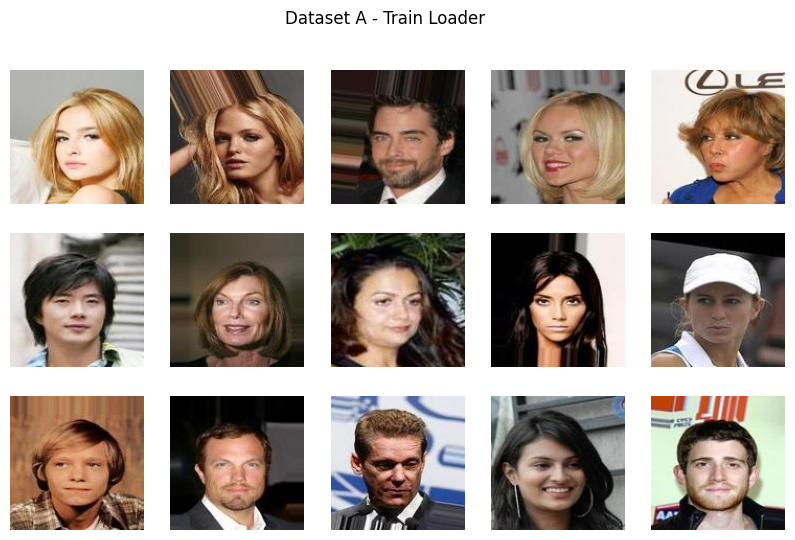

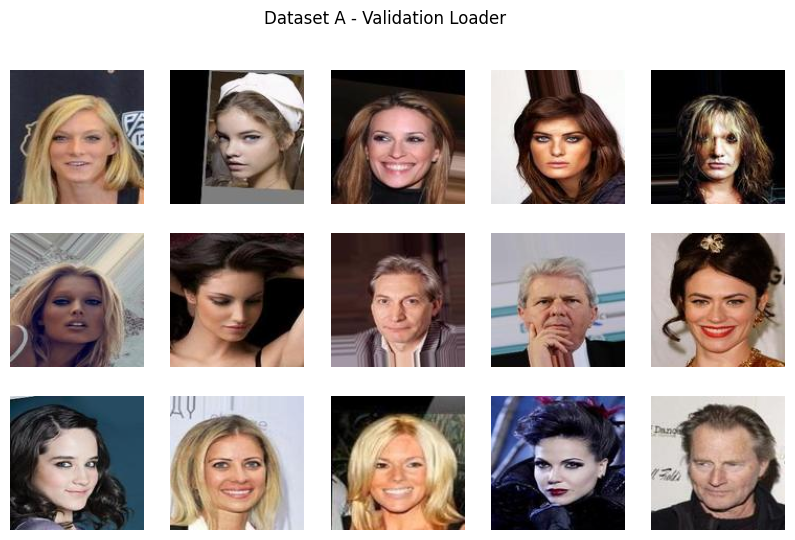

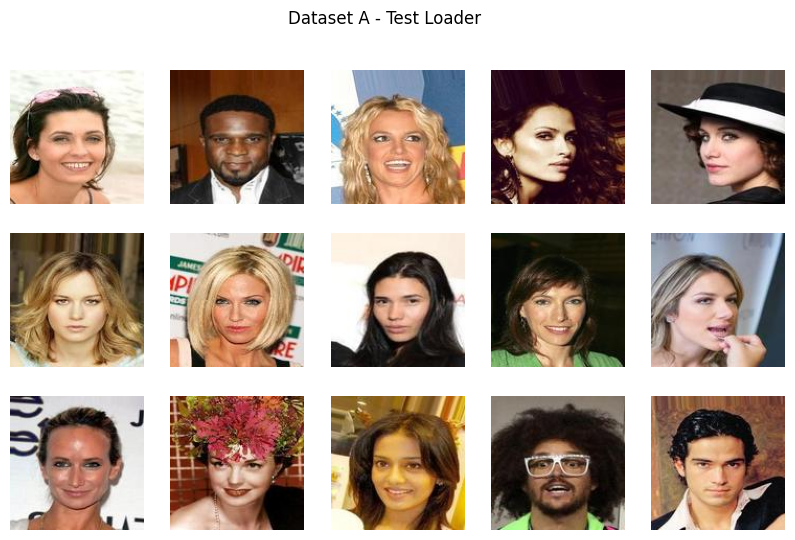

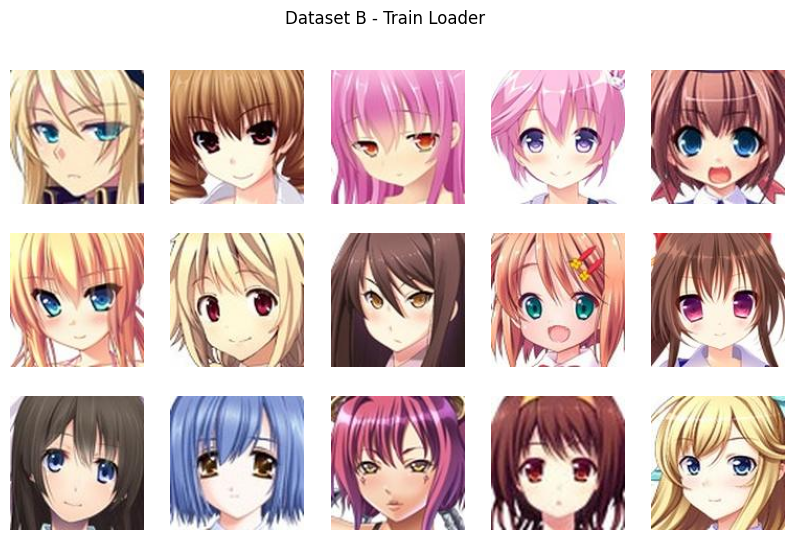

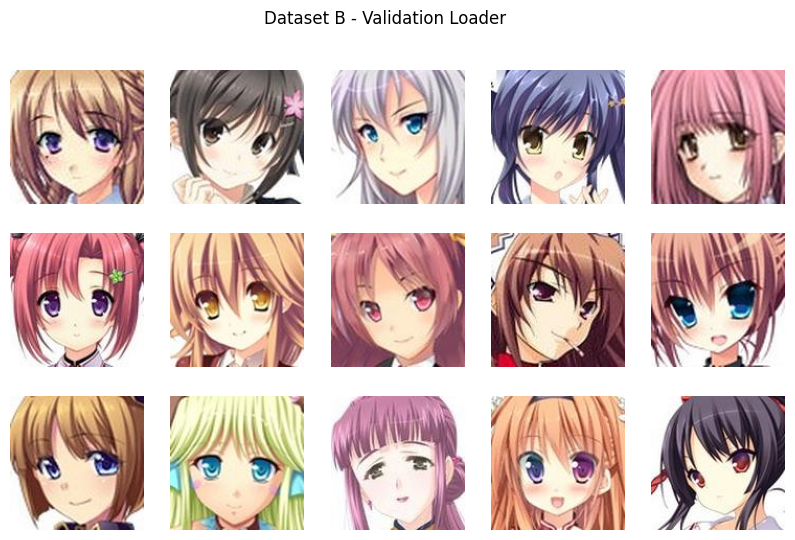

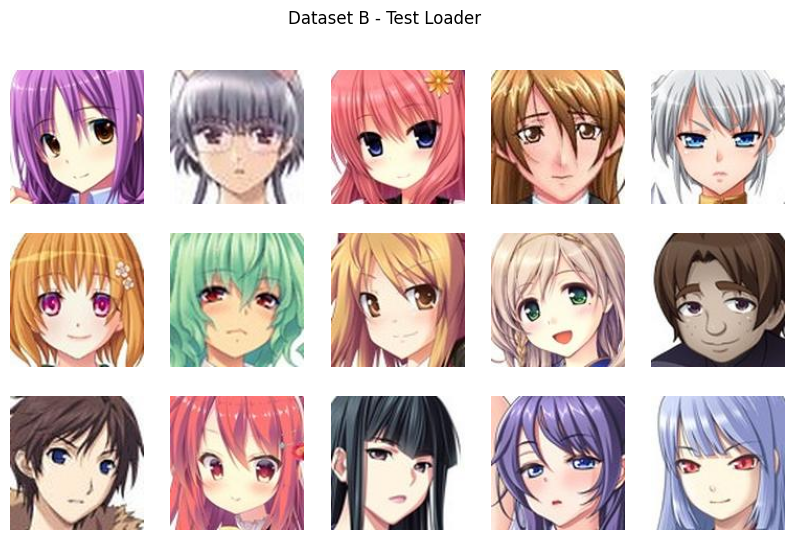

In [6]:
import matplotlib.pyplot as plt

# Taken from Lab 2
def visualize_data_loader(data_loader, title, num_images=15):
    k = 0
    plt.figure(figsize=(10, 6))
    for images, labels in data_loader:
        for i in range(images.size(0)):  
            if k >= num_images:
                break
            image = images[i]
            img = np.transpose(image.numpy(), [1, 2, 0])
            img = img / 2 + 0.5
            plt.subplot(3, 5, k+1)
            plt.axis('off')
            plt.imshow(img)
            k += 1
        if k >= num_images:
            break
    plt.suptitle(title)
    plt.show()

# Visualize dataset A
visualize_data_loader(train_loader_A, title="Dataset A - Train Loader")
visualize_data_loader(val_loader_A, title="Dataset A - Validation Loader")
visualize_data_loader(test_loader_A, title="Dataset A - Test Loader")

# Visualize dataset B
visualize_data_loader(train_loader_B, title="Dataset B - Train Loader")
visualize_data_loader(val_loader_B, title="Dataset B - Validation Loader")
visualize_data_loader(test_loader_B, title="Dataset B - Test Loader")

## 2. Model Building and Sanity Check

#### 2.1 Generator

In [7]:
class transconv_block(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    super(transconv_block,self).__init__()
    self.transconv_block=nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
  def forward(self,x):
    return self.transconv_block(x)

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super(conv_block, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.conv_block(x)

In [16]:
class Generator(nn.Module):
  def __init__(self):
      super(Generator, self).__init__()

      self.enc_layer1 = conv_block(6, 8)  # Modified input channel. Find root cause
      self.enc_layer2 = conv_block(8, 16)
      self.enc_layer3 = conv_block(16, 32)
      self.enc_layer4 = conv_block(32, 64)
      self.enc_layer5 = conv_block(64, 128)
      self.bottleneck = conv_block(128, 256, kernel_size=4, stride=1, padding=0)

      self.dec_layer1 = transconv_block(256, 128, kernel_size=4, stride=1, padding=0)
      self.dec_layer2 = transconv_block(256, 64)
      self.dec_layer3 = transconv_block(128, 32)
      self.dec_layer4 = transconv_block(64, 16)
      self.dec_layer5 = transconv_block(32, 8)
      self.dec_layer6 = transconv_block(16, 3)
      self.dec_layer7 = nn.ConvTranspose2d(6, 3, kernel_size=1, stride=1, padding=0)

  def forward(self, x, z):
      z = z.view(z.size(0), 3, 128, 128)
      x = x.view(-1, 3, 128, 128)
      x_noisy = torch.cat([z, x], 1)
      enc1 = self.enc_layer1(x_noisy)
      enc2 = self.enc_layer2(enc1)
      enc3 = self.enc_layer3(enc2)
      enc4 = self.enc_layer4(enc3)
      enc5 = self.enc_layer5(enc4)
      latent = self.bottleneck(enc5)
      dec1 = torch.cat([self.dec_layer1(latent), enc5], 1)
      dec2 = torch.cat([self.dec_layer2(dec1), enc4], 1)
      dec3 = torch.cat([self.dec_layer3(dec2), enc3], 1)
      dec4 = torch.cat([self.dec_layer4(dec3), enc2], 1)
      dec5 = torch.cat([self.dec_layer5(dec4), enc1], 1)
      dec6 = torch.cat([self.dec_layer6(dec5), x], 1)
      output = self.dec_layer7(dec6)

      return output

#### 2.2 Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            conv_block(6, 8),  # Adjust input channels to 6 (3 from real/fake_A + 3 from real_B)
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        x=x.view(-1,3,128,128)
        y=y.view(-1,3,128,128)
        concat = torch.cat([x, y], 1)  # Concatenate along the channel dimension
        out = self.model(concat)
        label = out.view(out.size(0), -1)
        return label  # real/fake

#### 2.3 Weight Initialization

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
#Clearing cache
import gc
torch.cuda.empty_cache()
gc.collect()

58918

## 3 Training Code

In [12]:
epoch_loop = tqdm(zip(train_loader_A, train_loader_B), total=min(len(train_loader_A), len(train_loader_B)), leave=True, desc="Iteration")
print(len(epoch_loop))

Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

110


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE_GEN = 2e-4
LEARNING_RATE_DISC = 2e-4
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
BATCH_SIZE = 32

start_time = time.time()

torch.manual_seed(1000)

factor = 1

generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

generator.train()
discriminator.train()

opt_Gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE_GEN, betas=(0.5, 0.999))
opt_Disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_DISC, betas=(0.5, 0.999))

loss = nn.BCEWithLogitsLoss()

writer_real_A = SummaryWriter(f"logs/real_A")
writer_fake_B = SummaryWriter(f"logs/fake_B")
writer_real_B = SummaryWriter(f"logs/real_B")
writer_fake_A = SummaryWriter(f"logs/fake_A")
step = 0

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    epoch_loop = tqdm(zip(train_loader_A, train_loader_B), total=min(len(train_loader_A), len(train_loader_B)), leave=True, desc="Iteration")
    
    for batch_idx, ((real_A, _), (real_B, _)) in enumerate(epoch_loop):

        if batch_idx < len(epoch_loop)-1:
            opt_Gen.zero_grad()
            opt_Disc.zero_grad()

            real_A = real_A.to(device)
            real_B = real_B.to(device)

            if batch_idx % factor == 0:
                ### Discriminator ###
                # For real data
                real_labels = torch.ones((real_A.size(0), 1), device=device) * 0.9
                loss_real = loss(discriminator(real_A, real_B), real_labels)
                #print(f"Discriminator real output shape: {discriminator(real_A, real_B).shape}, real_labels shape: {real_labels.shape}")

                # For fake data
                z = torch.randn(real_A.size(0), 3, IMAGE_SIZE, IMAGE_SIZE).to(device)  # Adjust z shape to [batch_size, 3, 128, 128]
                fake_labels = torch.ones((real_A.size(0),1), device=device) * 0.1
                fake_labels = fake_labels.view(-1, 1)
                fake = generator(real_A, z).detach()
                loss_fake = loss(discriminator(real_A, fake), fake_labels)
                #print(f"Discriminator fake output shape: {discriminator(real_A, fake).shape}, fake_labels shape: {fake_labels.shape}")
                

                loss_Disc_A = loss_real + loss_fake
                loss_Disc_A.backward()
                opt_Disc.step()

            ### Generator ###
            z = torch.rand(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)  # Adjust z shape to [batch_size, 3, 128, 128]
            gen_labels = torch.ones((real_A.size(0),1), device=device)
            #gen_labels = gen_labels.view(-1, 1)
            fake = generator(real_A, z)
            loss_Gen_A = loss(discriminator(real_A, fake), gen_labels)
            #print(f"Generator output shape: {discriminator(real_A, fake).shape}, gen_labels shape: {gen_labels.shape}, discriminator output shape: {discriminator(real_A, fake).shape}")
            loss_Gen_A.backward()
            opt_Gen.step()

            print(f"Batch {batch_idx}: Loss_Disc_A: {loss_Disc_A}, Loss_Gen_A: {loss_Gen_A}")
            # TensorBoard logging
            if batch_idx % 100 == 0:
                with torch.no_grad():
                    img_grid_real_A = torchvision.utils.make_grid(real_A[:32], normalize=True)
                    img_grid_fake_B = torchvision.utils.make_grid(generator(real_A, z)[:32], normalize=True)
                    img_grid_real_B = torchvision.utils.make_grid(real_B[:32], normalize=True)
                    img_grid_fake_A = torchvision.utils.make_grid(generator(real_B, z)[:32], normalize=True)

                    writer_real_A.add_image("Real_A", img_grid_real_A, global_step=step)
                    writer_fake_B.add_image("Fake_B", img_grid_fake_B, global_step=step)
                    writer_real_B.add_image("Real_B", img_grid_real_B, global_step=step)
                    writer_fake_A.add_image("Fake_A", img_grid_fake_A, global_step=step)
                step += 1
            
            torch.cuda.empty_cache()
            del real_A, real_B, z, loss_Disc_A, loss_Gen_A

print("Training Done")
end_time = time.time()
print(f"Time taken: {end_time - start_time}")

Epoch [1/5]


Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Batch 0: Loss_Disc_A: 1.5298882722854614, Loss_Gen_A: 0.5510329008102417


Iteration:   3%|▎         | 3/110 [00:02<00:57,  1.87it/s]

Batch 1: Loss_Disc_A: 1.3884210586547852, Loss_Gen_A: 0.6008505821228027
Batch 2: Loss_Disc_A: 1.3172863721847534, Loss_Gen_A: 0.6200211048126221


Iteration:   5%|▍         | 5/110 [00:02<00:32,  3.28it/s]

Batch 3: Loss_Disc_A: 1.2536345720291138, Loss_Gen_A: 0.6483325958251953
Batch 4: Loss_Disc_A: 1.1819593906402588, Loss_Gen_A: 0.6691408753395081


Iteration:   5%|▌         | 6/110 [00:02<00:27,  3.82it/s]

Batch 5: Loss_Disc_A: 1.1506528854370117, Loss_Gen_A: 0.6719597578048706


Iteration:   7%|▋         | 8/110 [00:02<00:23,  4.34it/s]

Batch 6: Loss_Disc_A: 1.1426339149475098, Loss_Gen_A: 0.6770762205123901
Batch 7: Loss_Disc_A: 1.1337306499481201, Loss_Gen_A: 0.6789971590042114


Iteration:   8%|▊         | 9/110 [00:03<00:21,  4.62it/s]

Batch 8: Loss_Disc_A: 1.125870704650879, Loss_Gen_A: 0.6826489567756653


Iteration:  10%|█         | 11/110 [00:03<00:20,  4.90it/s]

Batch 9: Loss_Disc_A: 1.1288251876831055, Loss_Gen_A: 0.6797817945480347
Batch 10: Loss_Disc_A: 1.1660802364349365, Loss_Gen_A: 0.6616671085357666


Iteration:  11%|█         | 12/110 [00:03<00:18,  5.21it/s]

Batch 11: Loss_Disc_A: 1.13222074508667, Loss_Gen_A: 0.6820474863052368
Batch 12: Loss_Disc_A: 1.1377066373825073, Loss_Gen_A: 0.6796877384185791


Iteration:  14%|█▎        | 15/110 [00:04<00:17,  5.42it/s]

Batch 13: Loss_Disc_A: 1.1265418529510498, Loss_Gen_A: 0.6828543543815613
Batch 14: Loss_Disc_A: 1.1155434846878052, Loss_Gen_A: 0.6860963106155396


Iteration:  15%|█▌        | 17/110 [00:04<00:15,  5.94it/s]

Batch 15: Loss_Disc_A: 1.1178733110427856, Loss_Gen_A: 0.6848184466362
Batch 16: Loss_Disc_A: 1.1183339357376099, Loss_Gen_A: 0.6848428249359131


Iteration:  17%|█▋        | 19/110 [00:04<00:15,  6.05it/s]

Batch 17: Loss_Disc_A: 1.1139225959777832, Loss_Gen_A: 0.6894903182983398
Batch 18: Loss_Disc_A: 1.1130781173706055, Loss_Gen_A: 0.6882288455963135


Iteration:  19%|█▉        | 21/110 [00:05<00:14,  6.13it/s]

Batch 19: Loss_Disc_A: 1.1123714447021484, Loss_Gen_A: 0.6900508403778076
Batch 20: Loss_Disc_A: 1.1107301712036133, Loss_Gen_A: 0.6896336078643799


Iteration:  21%|██        | 23/110 [00:05<00:15,  5.61it/s]

Batch 21: Loss_Disc_A: 1.1170369386672974, Loss_Gen_A: 0.6883118152618408
Batch 22: Loss_Disc_A: 1.1152832508087158, Loss_Gen_A: 0.6886918544769287


Iteration:  23%|██▎       | 25/110 [00:06<00:17,  4.83it/s]

Batch 23: Loss_Disc_A: 1.1154627799987793, Loss_Gen_A: 0.689026951789856
Batch 24: Loss_Disc_A: 1.1125028133392334, Loss_Gen_A: 0.6899296045303345


Iteration:  25%|██▍       | 27/110 [00:06<00:14,  5.55it/s]

Batch 25: Loss_Disc_A: 1.1129422187805176, Loss_Gen_A: 0.6874958872795105
Batch 26: Loss_Disc_A: 1.1116193532943726, Loss_Gen_A: 0.6890192627906799


Iteration:  26%|██▋       | 29/110 [00:06<00:13,  5.86it/s]

Batch 27: Loss_Disc_A: 1.1179234981536865, Loss_Gen_A: 0.6906048059463501
Batch 28: Loss_Disc_A: 1.1083818674087524, Loss_Gen_A: 0.6910500526428223


Iteration:  28%|██▊       | 31/110 [00:07<00:13,  5.76it/s]

Batch 29: Loss_Disc_A: 1.117244839668274, Loss_Gen_A: 0.6885620951652527
Batch 30: Loss_Disc_A: 1.1096510887145996, Loss_Gen_A: 0.6900243163108826


Iteration:  29%|██▉       | 32/110 [00:07<00:16,  4.62it/s]

Batch 31: Loss_Disc_A: 1.1102195978164673, Loss_Gen_A: 0.691222608089447


Iteration:  31%|███       | 34/110 [00:07<00:17,  4.36it/s]

Batch 32: Loss_Disc_A: 1.116384744644165, Loss_Gen_A: 0.6866276860237122
Batch 33: Loss_Disc_A: 1.1078159809112549, Loss_Gen_A: 0.6919847726821899


Iteration:  33%|███▎      | 36/110 [00:08<00:15,  4.77it/s]

Batch 34: Loss_Disc_A: 1.1098105907440186, Loss_Gen_A: 0.6911002993583679
Batch 35: Loss_Disc_A: 1.1077089309692383, Loss_Gen_A: 0.6922187209129333


Iteration:  35%|███▍      | 38/110 [00:08<00:13,  5.46it/s]

Batch 36: Loss_Disc_A: 1.11098051071167, Loss_Gen_A: 0.6910747289657593
Batch 37: Loss_Disc_A: 1.1087533235549927, Loss_Gen_A: 0.6915138363838196


Iteration:  36%|███▋      | 40/110 [00:08<00:11,  5.96it/s]

Batch 38: Loss_Disc_A: 1.1105549335479736, Loss_Gen_A: 0.6912341117858887
Batch 39: Loss_Disc_A: 1.1069896221160889, Loss_Gen_A: 0.6926154494285583


Iteration:  38%|███▊      | 42/110 [00:09<00:10,  6.38it/s]

Batch 40: Loss_Disc_A: 1.107804298400879, Loss_Gen_A: 0.6923373937606812
Batch 41: Loss_Disc_A: 1.1086777448654175, Loss_Gen_A: 0.6906393766403198


Iteration:  39%|███▉      | 43/110 [00:09<00:09,  6.73it/s]

Batch 42: Loss_Disc_A: 1.107663631439209, Loss_Gen_A: 0.6917603015899658


Iteration:  40%|████      | 44/110 [00:09<00:12,  5.26it/s]

Batch 43: Loss_Disc_A: 1.1089428663253784, Loss_Gen_A: 0.691204309463501


Iteration:  42%|████▏     | 46/110 [00:10<00:13,  4.61it/s]

Batch 44: Loss_Disc_A: 1.110351324081421, Loss_Gen_A: 0.6905220746994019
Batch 45: Loss_Disc_A: 1.1090784072875977, Loss_Gen_A: 0.6906180381774902


Iteration:  44%|████▎     | 48/110 [00:10<00:11,  5.24it/s]

Batch 46: Loss_Disc_A: 1.1097270250320435, Loss_Gen_A: 0.6907524466514587
Batch 47: Loss_Disc_A: 1.1116783618927002, Loss_Gen_A: 0.6912603378295898


Iteration:  45%|████▍     | 49/110 [00:10<00:11,  5.47it/s]

Batch 48: Loss_Disc_A: 1.1079812049865723, Loss_Gen_A: 0.6912471055984497


Iteration:  45%|████▌     | 50/110 [00:11<00:14,  4.19it/s]

Batch 49: Loss_Disc_A: 1.1131761074066162, Loss_Gen_A: 0.6898694634437561


Iteration:  46%|████▋     | 51/110 [00:11<00:14,  4.08it/s]

Batch 50: Loss_Disc_A: 1.114576816558838, Loss_Gen_A: 0.6916842460632324


Iteration:  48%|████▊     | 53/110 [00:12<00:18,  3.16it/s]

Batch 51: Loss_Disc_A: 1.1084375381469727, Loss_Gen_A: 0.6914694905281067
Batch 52: Loss_Disc_A: 1.1080106496810913, Loss_Gen_A: 0.6919143795967102


Iteration:  49%|████▉     | 54/110 [00:12<00:16,  3.45it/s]

Batch 53: Loss_Disc_A: 1.1083226203918457, Loss_Gen_A: 0.6923215389251709


Iteration:  50%|█████     | 55/110 [00:12<00:15,  3.54it/s]

Batch 54: Loss_Disc_A: 1.1090173721313477, Loss_Gen_A: 0.690833330154419


Iteration:  52%|█████▏    | 57/110 [00:13<00:13,  4.02it/s]

Batch 55: Loss_Disc_A: 1.1091734170913696, Loss_Gen_A: 0.6918549537658691
Batch 56: Loss_Disc_A: 1.112459421157837, Loss_Gen_A: 0.690498948097229


Iteration:  54%|█████▎    | 59/110 [00:13<00:10,  4.69it/s]

Batch 57: Loss_Disc_A: 1.1106187105178833, Loss_Gen_A: 0.6903347373008728
Batch 58: Loss_Disc_A: 1.11576509475708, Loss_Gen_A: 0.6907957792282104


Iteration:  55%|█████▌    | 61/110 [00:13<00:08,  5.46it/s]

Batch 59: Loss_Disc_A: 1.1068867444992065, Loss_Gen_A: 0.6924595832824707
Batch 60: Loss_Disc_A: 1.108498454093933, Loss_Gen_A: 0.691672682762146


Iteration:  56%|█████▋    | 62/110 [00:13<00:08,  5.93it/s]

Batch 61: Loss_Disc_A: 1.1093201637268066, Loss_Gen_A: 0.690304160118103


Iteration:  58%|█████▊    | 64/110 [00:14<00:08,  5.66it/s]

Batch 62: Loss_Disc_A: 1.1083617210388184, Loss_Gen_A: 0.6912261247634888
Batch 63: Loss_Disc_A: 1.1075708866119385, Loss_Gen_A: 0.6911693811416626


Iteration:  59%|█████▉    | 65/110 [00:14<00:08,  5.50it/s]

Batch 64: Loss_Disc_A: 1.1133813858032227, Loss_Gen_A: 0.6913111805915833


Iteration:  60%|██████    | 66/110 [00:14<00:08,  5.10it/s]

Batch 65: Loss_Disc_A: 1.1102826595306396, Loss_Gen_A: 0.6903254389762878


Iteration:  62%|██████▏   | 68/110 [00:15<00:08,  5.17it/s]

Batch 66: Loss_Disc_A: 1.1083059310913086, Loss_Gen_A: 0.6907792091369629
Batch 67: Loss_Disc_A: 1.1069142818450928, Loss_Gen_A: 0.6922715902328491


Iteration:  64%|██████▎   | 70/110 [00:15<00:06,  5.86it/s]

Batch 68: Loss_Disc_A: 1.1069356203079224, Loss_Gen_A: 0.692240834236145
Batch 69: Loss_Disc_A: 1.1071209907531738, Loss_Gen_A: 0.6920903921127319


Iteration:  65%|██████▌   | 72/110 [00:15<00:06,  5.70it/s]

Batch 70: Loss_Disc_A: 1.1074981689453125, Loss_Gen_A: 0.6917896270751953
Batch 71: Loss_Disc_A: 1.1086905002593994, Loss_Gen_A: 0.6902459859848022


Iteration:  67%|██████▋   | 74/110 [00:16<00:05,  6.44it/s]

Batch 72: Loss_Disc_A: 1.1081678867340088, Loss_Gen_A: 0.6902300119400024
Batch 73: Loss_Disc_A: 1.107143521308899, Loss_Gen_A: 0.6922573447227478


Iteration:  69%|██████▉   | 76/110 [00:16<00:04,  7.43it/s]

Batch 74: Loss_Disc_A: 1.1076875925064087, Loss_Gen_A: 0.6905472278594971
Batch 75: Loss_Disc_A: 1.1073203086853027, Loss_Gen_A: 0.6915907859802246


Iteration:  71%|███████   | 78/110 [00:16<00:03,  8.00it/s]

Batch 76: Loss_Disc_A: 1.1069104671478271, Loss_Gen_A: 0.6920958757400513
Batch 77: Loss_Disc_A: 1.107053518295288, Loss_Gen_A: 0.6923494338989258


Iteration:  73%|███████▎  | 80/110 [00:16<00:04,  7.19it/s]

Batch 78: Loss_Disc_A: 1.1074246168136597, Loss_Gen_A: 0.6918630599975586
Batch 79: Loss_Disc_A: 1.1070020198822021, Loss_Gen_A: 0.6918177604675293


Iteration:  75%|███████▍  | 82/110 [00:17<00:04,  6.52it/s]

Batch 80: Loss_Disc_A: 1.1069202423095703, Loss_Gen_A: 0.6913008689880371
Batch 81: Loss_Disc_A: 1.1077311038970947, Loss_Gen_A: 0.6906676292419434


Iteration:  76%|███████▋  | 84/110 [00:17<00:04,  6.33it/s]

Batch 82: Loss_Disc_A: 1.1069908142089844, Loss_Gen_A: 0.6917891502380371
Batch 83: Loss_Disc_A: 1.10750150680542, Loss_Gen_A: 0.6867008209228516


Iteration:  78%|███████▊  | 86/110 [00:17<00:03,  6.80it/s]

Batch 84: Loss_Disc_A: 1.110212802886963, Loss_Gen_A: 0.6886353492736816
Batch 85: Loss_Disc_A: 1.1096359491348267, Loss_Gen_A: 0.6737196445465088


Iteration:  80%|████████  | 88/110 [00:17<00:02,  7.37it/s]

Batch 86: Loss_Disc_A: 1.1588079929351807, Loss_Gen_A: 0.6744371652603149
Batch 87: Loss_Disc_A: 1.1764994859695435, Loss_Gen_A: 0.6832643151283264


Iteration:  82%|████████▏ | 90/110 [00:18<00:02,  6.78it/s]

Batch 88: Loss_Disc_A: 1.1318720579147339, Loss_Gen_A: 0.6819446086883545
Batch 89: Loss_Disc_A: 1.124851942062378, Loss_Gen_A: 0.6774330139160156


Iteration:  84%|████████▎ | 92/110 [00:18<00:02,  6.89it/s]

Batch 90: Loss_Disc_A: 1.120872974395752, Loss_Gen_A: 0.6917098760604858
Batch 91: Loss_Disc_A: 1.1127703189849854, Loss_Gen_A: 0.6920795440673828


Iteration:  85%|████████▌ | 94/110 [00:18<00:02,  7.23it/s]

Batch 92: Loss_Disc_A: 1.1111533641815186, Loss_Gen_A: 0.6922110319137573
Batch 93: Loss_Disc_A: 1.1084953546524048, Loss_Gen_A: 0.6927751898765564


Iteration:  87%|████████▋ | 96/110 [00:19<00:01,  7.35it/s]

Batch 94: Loss_Disc_A: 1.1134748458862305, Loss_Gen_A: 0.689520001411438
Batch 95: Loss_Disc_A: 1.1231106519699097, Loss_Gen_A: 0.6926912069320679


Iteration:  89%|████████▉ | 98/110 [00:19<00:01,  6.32it/s]

Batch 96: Loss_Disc_A: 1.1095579862594604, Loss_Gen_A: 0.6918987035751343
Batch 97: Loss_Disc_A: 1.1086838245391846, Loss_Gen_A: 0.6920496225357056


Iteration:  91%|█████████ | 100/110 [00:19<00:01,  6.55it/s]

Batch 98: Loss_Disc_A: 1.1078288555145264, Loss_Gen_A: 0.6921103000640869
Batch 99: Loss_Disc_A: 1.1090017557144165, Loss_Gen_A: 0.6924945116043091
Batch 100: Loss_Disc_A: 1.1077284812927246, Loss_Gen_A: 0.6922320127487183


Iteration:  94%|█████████▎| 103/110 [00:21<00:02,  2.63it/s]

Batch 101: Loss_Disc_A: 1.107608675956726, Loss_Gen_A: 0.6921742558479309
Batch 102: Loss_Disc_A: 1.1111464500427246, Loss_Gen_A: 0.6915909051895142


Iteration:  95%|█████████▌| 105/110 [00:21<00:01,  3.90it/s]

Batch 103: Loss_Disc_A: 1.1082119941711426, Loss_Gen_A: 0.6929192543029785
Batch 104: Loss_Disc_A: 1.1072134971618652, Loss_Gen_A: 0.6926851272583008


Iteration:  97%|█████████▋| 107/110 [00:22<00:00,  5.02it/s]

Batch 105: Loss_Disc_A: 1.1074285507202148, Loss_Gen_A: 0.6920750141143799
Batch 106: Loss_Disc_A: 1.107654333114624, Loss_Gen_A: 0.6922527551651001


Iteration: 100%|██████████| 110/110 [00:22<00:00,  4.87it/s]


Batch 107: Loss_Disc_A: 1.1087346076965332, Loss_Gen_A: 0.6923680305480957
Batch 108: Loss_Disc_A: 1.1086772680282593, Loss_Gen_A: 0.6924651861190796
Epoch [2/5]


Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Batch 0: Loss_Disc_A: 1.1069480180740356, Loss_Gen_A: 0.6927808523178101


Iteration:   3%|▎         | 3/110 [00:01<00:45,  2.33it/s]

Batch 1: Loss_Disc_A: 1.1069930791854858, Loss_Gen_A: 0.6925729513168335
Batch 2: Loss_Disc_A: 1.1070457696914673, Loss_Gen_A: 0.6926826238632202


Iteration:   5%|▍         | 5/110 [00:01<00:25,  4.16it/s]

Batch 3: Loss_Disc_A: 1.108665943145752, Loss_Gen_A: 0.6915495991706848
Batch 4: Loss_Disc_A: 1.1108447313308716, Loss_Gen_A: 0.6922975778579712


Iteration:   6%|▋         | 7/110 [00:02<00:20,  4.98it/s]

Batch 5: Loss_Disc_A: 1.1067085266113281, Loss_Gen_A: 0.692945659160614
Batch 6: Loss_Disc_A: 1.1067427396774292, Loss_Gen_A: 0.6930392980575562


Iteration:   8%|▊         | 9/110 [00:02<00:16,  6.05it/s]

Batch 7: Loss_Disc_A: 1.1077252626419067, Loss_Gen_A: 0.69209223985672
Batch 8: Loss_Disc_A: 1.1164063215255737, Loss_Gen_A: 0.6923550367355347


Iteration:  10%|█         | 11/110 [00:02<00:14,  6.91it/s]

Batch 9: Loss_Disc_A: 1.1067390441894531, Loss_Gen_A: 0.693067193031311
Batch 10: Loss_Disc_A: 1.107125997543335, Loss_Gen_A: 0.6925627589225769


Iteration:  12%|█▏        | 13/110 [00:03<00:12,  7.67it/s]

Batch 11: Loss_Disc_A: 1.1074949502944946, Loss_Gen_A: 0.6922464966773987
Batch 12: Loss_Disc_A: 1.1072105169296265, Loss_Gen_A: 0.692245602607727


Iteration:  13%|█▎        | 14/110 [00:03<00:12,  7.66it/s]

Batch 13: Loss_Disc_A: 1.1069093942642212, Loss_Gen_A: 0.6928998827934265


Iteration:  15%|█▍        | 16/110 [00:03<00:19,  4.73it/s]

Batch 14: Loss_Disc_A: 1.1069592237472534, Loss_Gen_A: 0.6928609609603882
Batch 15: Loss_Disc_A: 1.109419584274292, Loss_Gen_A: 0.6922049522399902


Iteration:  16%|█▋        | 18/110 [00:03<00:15,  6.06it/s]

Batch 16: Loss_Disc_A: 1.1067651510238647, Loss_Gen_A: 0.6927533745765686
Batch 17: Loss_Disc_A: 1.1068854331970215, Loss_Gen_A: 0.6928009986877441


Iteration:  18%|█▊        | 20/110 [00:04<00:13,  6.47it/s]

Batch 18: Loss_Disc_A: 1.1068154573440552, Loss_Gen_A: 0.6928974390029907
Batch 19: Loss_Disc_A: 1.106804370880127, Loss_Gen_A: 0.6928253173828125


Iteration:  20%|██        | 22/110 [00:04<00:13,  6.40it/s]

Batch 20: Loss_Disc_A: 1.1066733598709106, Loss_Gen_A: 0.6928515434265137
Batch 21: Loss_Disc_A: 1.1073063611984253, Loss_Gen_A: 0.6927065849304199


Iteration:  22%|██▏       | 24/110 [00:04<00:12,  6.79it/s]

Batch 22: Loss_Disc_A: 1.1066091060638428, Loss_Gen_A: 0.6928582191467285
Batch 23: Loss_Disc_A: 1.106935739517212, Loss_Gen_A: 0.6928986310958862


Iteration:  24%|██▎       | 26/110 [00:05<00:11,  7.46it/s]

Batch 24: Loss_Disc_A: 1.1067464351654053, Loss_Gen_A: 0.6926894187927246
Batch 25: Loss_Disc_A: 1.1069188117980957, Loss_Gen_A: 0.6928079128265381


Iteration:  25%|██▌       | 28/110 [00:05<00:11,  7.41it/s]

Batch 26: Loss_Disc_A: 1.1066395044326782, Loss_Gen_A: 0.692981481552124
Batch 27: Loss_Disc_A: 1.1064727306365967, Loss_Gen_A: 0.6930984258651733


Iteration:  27%|██▋       | 30/110 [00:05<00:10,  7.74it/s]

Batch 28: Loss_Disc_A: 1.1066560745239258, Loss_Gen_A: 0.692949116230011
Batch 29: Loss_Disc_A: 1.1069493293762207, Loss_Gen_A: 0.6929948329925537


Iteration:  29%|██▉       | 32/110 [00:05<00:10,  7.44it/s]

Batch 30: Loss_Disc_A: 1.1067736148834229, Loss_Gen_A: 0.6929284334182739
Batch 31: Loss_Disc_A: 1.107072353363037, Loss_Gen_A: 0.6923667192459106


Iteration:  30%|███       | 33/110 [00:06<00:10,  7.30it/s]

Batch 32: Loss_Disc_A: 1.1066632270812988, Loss_Gen_A: 0.693013072013855


Iteration:  32%|███▏      | 35/110 [00:06<00:11,  6.54it/s]

Batch 33: Loss_Disc_A: 1.1067605018615723, Loss_Gen_A: 0.6922033429145813
Batch 34: Loss_Disc_A: 1.106595516204834, Loss_Gen_A: 0.6930413246154785


Iteration:  34%|███▎      | 37/110 [00:06<00:09,  7.30it/s]

Batch 35: Loss_Disc_A: 1.1069166660308838, Loss_Gen_A: 0.6928278207778931
Batch 36: Loss_Disc_A: 1.1068737506866455, Loss_Gen_A: 0.6925504207611084


Iteration:  35%|███▌      | 39/110 [00:06<00:10,  6.91it/s]

Batch 37: Loss_Disc_A: 1.1107666492462158, Loss_Gen_A: 0.6927110552787781
Batch 38: Loss_Disc_A: 1.10662841796875, Loss_Gen_A: 0.6930830478668213


Iteration:  37%|███▋      | 41/110 [00:07<00:09,  7.66it/s]

Batch 39: Loss_Disc_A: 1.1089115142822266, Loss_Gen_A: 0.6923778057098389
Batch 40: Loss_Disc_A: 1.1066994667053223, Loss_Gen_A: 0.6925854682922363


Iteration:  38%|███▊      | 42/110 [00:07<00:08,  7.94it/s]

Batch 41: Loss_Disc_A: 1.1066687107086182, Loss_Gen_A: 0.6929179430007935


Iteration:  40%|████      | 44/110 [00:07<00:13,  4.91it/s]

Batch 42: Loss_Disc_A: 1.1074190139770508, Loss_Gen_A: 0.6912299394607544
Batch 43: Loss_Disc_A: 1.1072685718536377, Loss_Gen_A: 0.6920498013496399


Iteration:  42%|████▏     | 46/110 [00:08<00:10,  6.19it/s]

Batch 44: Loss_Disc_A: 1.1148031949996948, Loss_Gen_A: 0.6916569471359253
Batch 45: Loss_Disc_A: 1.1076141595840454, Loss_Gen_A: 0.6915104389190674


Iteration:  43%|████▎     | 47/110 [00:08<00:10,  6.19it/s]

Batch 46: Loss_Disc_A: 1.1070075035095215, Loss_Gen_A: 0.692701518535614


Iteration:  45%|████▍     | 49/110 [00:08<00:09,  6.32it/s]

Batch 47: Loss_Disc_A: 1.1082887649536133, Loss_Gen_A: 0.6919393539428711
Batch 48: Loss_Disc_A: 1.1151560544967651, Loss_Gen_A: 0.6920589208602905


Iteration:  46%|████▋     | 51/110 [00:08<00:07,  7.48it/s]

Batch 49: Loss_Disc_A: 1.1097440719604492, Loss_Gen_A: 0.6919029951095581
Batch 50: Loss_Disc_A: 1.1258926391601562, Loss_Gen_A: 0.690081775188446


Iteration:  48%|████▊     | 53/110 [00:09<00:07,  8.08it/s]

Batch 51: Loss_Disc_A: 1.1071372032165527, Loss_Gen_A: 0.6923800706863403
Batch 52: Loss_Disc_A: 1.1089887619018555, Loss_Gen_A: 0.690929651260376


Iteration:  50%|█████     | 55/110 [00:09<00:07,  7.43it/s]

Batch 53: Loss_Disc_A: 1.108353853225708, Loss_Gen_A: 0.6910015940666199
Batch 54: Loss_Disc_A: 1.1073129177093506, Loss_Gen_A: 0.6921641826629639


Iteration:  52%|█████▏    | 57/110 [00:09<00:07,  7.43it/s]

Batch 55: Loss_Disc_A: 1.1135597229003906, Loss_Gen_A: 0.6920523047447205
Batch 56: Loss_Disc_A: 1.106677770614624, Loss_Gen_A: 0.692894697189331


Iteration:  54%|█████▎    | 59/110 [00:09<00:07,  7.22it/s]

Batch 57: Loss_Disc_A: 1.1074109077453613, Loss_Gen_A: 0.6923781633377075
Batch 58: Loss_Disc_A: 1.1083019971847534, Loss_Gen_A: 0.6925786733627319


Iteration:  55%|█████▌    | 61/110 [00:10<00:06,  7.59it/s]

Batch 59: Loss_Disc_A: 1.106823444366455, Loss_Gen_A: 0.6928653717041016
Batch 60: Loss_Disc_A: 1.1065596342086792, Loss_Gen_A: 0.6929235458374023


Iteration:  57%|█████▋    | 63/110 [00:10<00:06,  7.20it/s]

Batch 61: Loss_Disc_A: 1.1067781448364258, Loss_Gen_A: 0.6927539110183716
Batch 62: Loss_Disc_A: 1.106629729270935, Loss_Gen_A: 0.6929740905761719


Iteration:  59%|█████▉    | 65/110 [00:10<00:06,  7.37it/s]

Batch 63: Loss_Disc_A: 1.106581449508667, Loss_Gen_A: 0.6930066347122192
Batch 64: Loss_Disc_A: 1.1070313453674316, Loss_Gen_A: 0.6926664113998413


Iteration:  61%|██████    | 67/110 [00:11<00:05,  7.72it/s]

Batch 65: Loss_Disc_A: 1.1066052913665771, Loss_Gen_A: 0.692983865737915
Batch 66: Loss_Disc_A: 1.1067705154418945, Loss_Gen_A: 0.6927777528762817


Iteration:  63%|██████▎   | 69/110 [00:11<00:05,  7.41it/s]

Batch 67: Loss_Disc_A: 1.1074795722961426, Loss_Gen_A: 0.6918239593505859
Batch 68: Loss_Disc_A: 1.106724739074707, Loss_Gen_A: 0.6927719116210938


Iteration:  65%|██████▍   | 71/110 [00:11<00:05,  7.67it/s]

Batch 69: Loss_Disc_A: 1.1070342063903809, Loss_Gen_A: 0.6930778622627258
Batch 70: Loss_Disc_A: 1.1067044734954834, Loss_Gen_A: 0.6928569674491882


Iteration:  65%|██████▌   | 72/110 [00:11<00:05,  7.36it/s]

Batch 71: Loss_Disc_A: 1.1068611145019531, Loss_Gen_A: 0.6927958726882935


Iteration:  66%|██████▋   | 73/110 [00:11<00:05,  6.22it/s]

Batch 72: Loss_Disc_A: 1.1072548627853394, Loss_Gen_A: 0.6909921765327454
Batch 73: Loss_Disc_A: 1.107240080833435, Loss_Gen_A: 0.6926455497741699


Iteration:  69%|██████▉   | 76/110 [00:12<00:04,  6.85it/s]

Batch 74: Loss_Disc_A: 1.107064962387085, Loss_Gen_A: 0.6927980184555054
Batch 75: Loss_Disc_A: 1.1068034172058105, Loss_Gen_A: 0.6928374767303467


Iteration:  71%|███████   | 78/110 [00:12<00:04,  7.55it/s]

Batch 76: Loss_Disc_A: 1.1065905094146729, Loss_Gen_A: 0.6927478313446045
Batch 77: Loss_Disc_A: 1.10704505443573, Loss_Gen_A: 0.6926623582839966


Iteration:  73%|███████▎  | 80/110 [00:12<00:04,  7.20it/s]

Batch 78: Loss_Disc_A: 1.1082791090011597, Loss_Gen_A: 0.6915668249130249
Batch 79: Loss_Disc_A: 1.1068146228790283, Loss_Gen_A: 0.692678689956665


Iteration:  75%|███████▍  | 82/110 [00:13<00:04,  6.73it/s]

Batch 80: Loss_Disc_A: 1.1067233085632324, Loss_Gen_A: 0.6928805112838745
Batch 81: Loss_Disc_A: 1.1067503690719604, Loss_Gen_A: 0.6930710077285767


Iteration:  76%|███████▋  | 84/110 [00:13<00:03,  6.72it/s]

Batch 82: Loss_Disc_A: 1.1107795238494873, Loss_Gen_A: 0.691098690032959
Batch 83: Loss_Disc_A: 1.113762378692627, Loss_Gen_A: 0.6927312612533569


Iteration:  78%|███████▊  | 86/110 [00:13<00:03,  6.78it/s]

Batch 84: Loss_Disc_A: 1.1068899631500244, Loss_Gen_A: 0.692713737487793
Batch 85: Loss_Disc_A: 1.106763243675232, Loss_Gen_A: 0.6913256645202637


Iteration:  80%|████████  | 88/110 [00:14<00:03,  7.27it/s]

Batch 86: Loss_Disc_A: 1.1066629886627197, Loss_Gen_A: 0.692798912525177
Batch 87: Loss_Disc_A: 1.111039400100708, Loss_Gen_A: 0.6895933151245117


Iteration:  82%|████████▏ | 90/110 [00:14<00:02,  7.06it/s]

Batch 88: Loss_Disc_A: 1.109001874923706, Loss_Gen_A: 0.692806601524353
Batch 89: Loss_Disc_A: 1.1070609092712402, Loss_Gen_A: 0.6924822926521301


Iteration:  84%|████████▎ | 92/110 [00:14<00:02,  6.49it/s]

Batch 90: Loss_Disc_A: 1.107266902923584, Loss_Gen_A: 0.6929537057876587
Batch 91: Loss_Disc_A: 1.107090950012207, Loss_Gen_A: 0.6930701732635498


Iteration:  85%|████████▍ | 93/110 [00:14<00:02,  6.82it/s]

Batch 92: Loss_Disc_A: 1.1066510677337646, Loss_Gen_A: 0.6929574012756348


Iteration:  86%|████████▋ | 95/110 [00:15<00:03,  4.88it/s]

Batch 93: Loss_Disc_A: 1.1066190004348755, Loss_Gen_A: 0.6927024126052856
Batch 94: Loss_Disc_A: 1.1071059703826904, Loss_Gen_A: 0.6926202774047852


Iteration:  88%|████████▊ | 97/110 [00:15<00:02,  5.66it/s]

Batch 95: Loss_Disc_A: 1.1066159009933472, Loss_Gen_A: 0.6927922964096069
Batch 96: Loss_Disc_A: 1.1066118478775024, Loss_Gen_A: 0.6926440000534058


Iteration:  90%|█████████ | 99/110 [00:15<00:01,  6.38it/s]

Batch 97: Loss_Disc_A: 1.1065130233764648, Loss_Gen_A: 0.6930907964706421
Batch 98: Loss_Disc_A: 1.1084436178207397, Loss_Gen_A: 0.6897077560424805


Iteration:  91%|█████████ | 100/110 [00:16<00:01,  6.93it/s]

Batch 99: Loss_Disc_A: 1.1067354679107666, Loss_Gen_A: 0.6927831768989563
Batch 100: Loss_Disc_A: 1.1067403554916382, Loss_Gen_A: 0.6926432251930237


Iteration:  94%|█████████▎| 103/110 [00:17<00:02,  3.05it/s]

Batch 101: Loss_Disc_A: 1.1067460775375366, Loss_Gen_A: 0.6921405792236328
Batch 102: Loss_Disc_A: 1.1074881553649902, Loss_Gen_A: 0.6926360130310059


Iteration:  95%|█████████▌| 105/110 [00:17<00:01,  4.07it/s]

Batch 103: Loss_Disc_A: 1.1068884134292603, Loss_Gen_A: 0.692599356174469
Batch 104: Loss_Disc_A: 1.1071127653121948, Loss_Gen_A: 0.6927571892738342


Iteration:  97%|█████████▋| 107/110 [00:18<00:00,  5.07it/s]

Batch 105: Loss_Disc_A: 1.106567621231079, Loss_Gen_A: 0.6930973529815674
Batch 106: Loss_Disc_A: 1.1074094772338867, Loss_Gen_A: 0.6922221183776855


Iteration: 100%|██████████| 110/110 [00:18<00:00,  5.92it/s]


Batch 107: Loss_Disc_A: 1.1074222326278687, Loss_Gen_A: 0.691434383392334
Batch 108: Loss_Disc_A: 1.1235954761505127, Loss_Gen_A: 0.6891354322433472
Epoch [3/5]


Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Batch 0: Loss_Disc_A: 1.107688069343567, Loss_Gen_A: 0.6925849914550781


Iteration:   3%|▎         | 3/110 [00:01<00:46,  2.32it/s]

Batch 1: Loss_Disc_A: 1.1090725660324097, Loss_Gen_A: 0.692025899887085
Batch 2: Loss_Disc_A: 1.1096255779266357, Loss_Gen_A: 0.691189169883728


Iteration:   5%|▍         | 5/110 [00:01<00:27,  3.84it/s]

Batch 3: Loss_Disc_A: 1.1068956851959229, Loss_Gen_A: 0.6926887035369873
Batch 4: Loss_Disc_A: 1.1071498394012451, Loss_Gen_A: 0.6927123069763184


Iteration:   6%|▋         | 7/110 [00:02<00:21,  4.72it/s]

Batch 5: Loss_Disc_A: 1.107240080833435, Loss_Gen_A: 0.6924870014190674
Batch 6: Loss_Disc_A: 1.1073592901229858, Loss_Gen_A: 0.6924338340759277


Iteration:   8%|▊         | 9/110 [00:02<00:18,  5.39it/s]

Batch 7: Loss_Disc_A: 1.1067975759506226, Loss_Gen_A: 0.6927288174629211
Batch 8: Loss_Disc_A: 1.1069679260253906, Loss_Gen_A: 0.6919821500778198


Iteration:  10%|█         | 11/110 [00:02<00:16,  5.93it/s]

Batch 9: Loss_Disc_A: 1.106949806213379, Loss_Gen_A: 0.6923942565917969
Batch 10: Loss_Disc_A: 1.1077075004577637, Loss_Gen_A: 0.6915358304977417


Iteration:  12%|█▏        | 13/110 [00:03<00:16,  5.95it/s]

Batch 11: Loss_Disc_A: 1.1097978353500366, Loss_Gen_A: 0.6904454231262207
Batch 12: Loss_Disc_A: 1.1084330081939697, Loss_Gen_A: 0.6929047107696533


Iteration:  14%|█▎        | 15/110 [00:03<00:15,  6.12it/s]

Batch 13: Loss_Disc_A: 1.107347011566162, Loss_Gen_A: 0.6925262212753296
Batch 14: Loss_Disc_A: 1.1068084239959717, Loss_Gen_A: 0.6927849054336548


Iteration:  15%|█▌        | 17/110 [00:04<00:16,  5.56it/s]

Batch 15: Loss_Disc_A: 1.1098086833953857, Loss_Gen_A: 0.6914128065109253
Batch 16: Loss_Disc_A: 1.106909990310669, Loss_Gen_A: 0.6927277445793152


Iteration:  17%|█▋        | 19/110 [00:04<00:15,  6.06it/s]

Batch 17: Loss_Disc_A: 1.1095398664474487, Loss_Gen_A: 0.6920461654663086
Batch 18: Loss_Disc_A: 1.107987642288208, Loss_Gen_A: 0.692571222782135


Iteration:  19%|█▉        | 21/110 [00:04<00:13,  6.61it/s]

Batch 19: Loss_Disc_A: 1.1082122325897217, Loss_Gen_A: 0.692807674407959
Batch 20: Loss_Disc_A: 1.1073858737945557, Loss_Gen_A: 0.6901234984397888


Iteration:  21%|██        | 23/110 [00:04<00:13,  6.40it/s]

Batch 21: Loss_Disc_A: 1.1087608337402344, Loss_Gen_A: 0.6900125741958618
Batch 22: Loss_Disc_A: 1.1149876117706299, Loss_Gen_A: 0.6927916407585144


Iteration:  23%|██▎       | 25/110 [00:05<00:14,  6.00it/s]

Batch 23: Loss_Disc_A: 1.1122616529464722, Loss_Gen_A: 0.692668616771698
Batch 24: Loss_Disc_A: 1.1087942123413086, Loss_Gen_A: 0.6891661882400513


Iteration:  25%|██▍       | 27/110 [00:05<00:12,  6.78it/s]

Batch 25: Loss_Disc_A: 1.110759973526001, Loss_Gen_A: 0.6921470165252686
Batch 26: Loss_Disc_A: 1.1066433191299438, Loss_Gen_A: 0.6928274631500244


Iteration:  25%|██▌       | 28/110 [00:05<00:13,  6.30it/s]

Batch 27: Loss_Disc_A: 1.1080143451690674, Loss_Gen_A: 0.6925765872001648


Iteration:  27%|██▋       | 30/110 [00:06<00:13,  5.79it/s]

Batch 28: Loss_Disc_A: 1.107303261756897, Loss_Gen_A: 0.6917784810066223
Batch 29: Loss_Disc_A: 1.1067177057266235, Loss_Gen_A: 0.6929624676704407


Iteration:  29%|██▉       | 32/110 [00:06<00:13,  5.91it/s]

Batch 30: Loss_Disc_A: 1.1096011400222778, Loss_Gen_A: 0.69020015001297
Batch 31: Loss_Disc_A: 1.1080641746520996, Loss_Gen_A: 0.6915724277496338


Iteration:  31%|███       | 34/110 [00:06<00:11,  6.61it/s]

Batch 32: Loss_Disc_A: 1.106863021850586, Loss_Gen_A: 0.6924750208854675
Batch 33: Loss_Disc_A: 1.1086064577102661, Loss_Gen_A: 0.6920849084854126


Iteration:  33%|███▎      | 36/110 [00:07<00:11,  6.41it/s]

Batch 34: Loss_Disc_A: 1.1069380044937134, Loss_Gen_A: 0.6922340989112854
Batch 35: Loss_Disc_A: 1.1100825071334839, Loss_Gen_A: 0.6903053522109985


Iteration:  35%|███▍      | 38/110 [00:07<00:10,  7.00it/s]

Batch 36: Loss_Disc_A: 1.1079145669937134, Loss_Gen_A: 0.6921108365058899
Batch 37: Loss_Disc_A: 1.1068670749664307, Loss_Gen_A: 0.6929686665534973


Iteration:  36%|███▋      | 40/110 [00:07<00:10,  6.39it/s]

Batch 38: Loss_Disc_A: 1.1067659854888916, Loss_Gen_A: 0.6930438876152039
Batch 39: Loss_Disc_A: 1.1079840660095215, Loss_Gen_A: 0.6913325190544128


Iteration:  38%|███▊      | 42/110 [00:07<00:11,  5.99it/s]

Batch 40: Loss_Disc_A: 1.109582781791687, Loss_Gen_A: 0.6908243894577026
Batch 41: Loss_Disc_A: 1.1069183349609375, Loss_Gen_A: 0.6926594972610474


Iteration:  40%|████      | 44/110 [00:08<00:09,  6.79it/s]

Batch 42: Loss_Disc_A: 1.1099684238433838, Loss_Gen_A: 0.6909314393997192
Batch 43: Loss_Disc_A: 1.108762502670288, Loss_Gen_A: 0.688825249671936


Iteration:  41%|████      | 45/110 [00:08<00:10,  6.26it/s]

Batch 44: Loss_Disc_A: 1.11391282081604, Loss_Gen_A: 0.6927353143692017


Iteration:  43%|████▎     | 47/110 [00:08<00:10,  5.88it/s]

Batch 45: Loss_Disc_A: 1.1138994693756104, Loss_Gen_A: 0.6893638372421265
Batch 46: Loss_Disc_A: 1.1138241291046143, Loss_Gen_A: 0.6901477575302124


Iteration:  45%|████▍     | 49/110 [00:09<00:09,  6.43it/s]

Batch 47: Loss_Disc_A: 1.1079515218734741, Loss_Gen_A: 0.6929802298545837
Batch 48: Loss_Disc_A: 1.106807827949524, Loss_Gen_A: 0.6907984018325806


Iteration:  46%|████▋     | 51/110 [00:09<00:08,  6.88it/s]

Batch 49: Loss_Disc_A: 1.1073055267333984, Loss_Gen_A: 0.6911599636077881
Batch 50: Loss_Disc_A: 1.1076024770736694, Loss_Gen_A: 0.690815269947052


Iteration:  48%|████▊     | 53/110 [00:09<00:07,  7.42it/s]

Batch 51: Loss_Disc_A: 1.1068952083587646, Loss_Gen_A: 0.6911520957946777
Batch 52: Loss_Disc_A: 1.1144564151763916, Loss_Gen_A: 0.6903551816940308


Iteration:  49%|████▉     | 54/110 [00:09<00:07,  7.50it/s]

Batch 53: Loss_Disc_A: 1.1113481521606445, Loss_Gen_A: 0.6874951720237732


Iteration:  50%|█████     | 55/110 [00:10<00:13,  4.22it/s]

Batch 54: Loss_Disc_A: 1.1204562187194824, Loss_Gen_A: 0.6907460689544678


Iteration:  51%|█████     | 56/110 [00:10<00:12,  4.28it/s]

Batch 55: Loss_Disc_A: 1.121650218963623, Loss_Gen_A: 0.6920018196105957


Iteration:  53%|█████▎    | 58/110 [00:10<00:11,  4.60it/s]

Batch 56: Loss_Disc_A: 1.1069433689117432, Loss_Gen_A: 0.692473292350769
Batch 57: Loss_Disc_A: 1.1128578186035156, Loss_Gen_A: 0.6924072504043579


Iteration:  55%|█████▍    | 60/110 [00:11<00:09,  5.03it/s]

Batch 58: Loss_Disc_A: 1.113372802734375, Loss_Gen_A: 0.6928125619888306
Batch 59: Loss_Disc_A: 1.1185104846954346, Loss_Gen_A: 0.6891701221466064


Iteration:  56%|█████▋    | 62/110 [00:11<00:07,  6.05it/s]

Batch 60: Loss_Disc_A: 1.1100268363952637, Loss_Gen_A: 0.6893962621688843
Batch 61: Loss_Disc_A: 1.1106775999069214, Loss_Gen_A: 0.6903209686279297


Iteration:  58%|█████▊    | 64/110 [00:11<00:07,  6.34it/s]

Batch 62: Loss_Disc_A: 1.1221811771392822, Loss_Gen_A: 0.6916712522506714
Batch 63: Loss_Disc_A: 1.107061743736267, Loss_Gen_A: 0.6928994655609131


Iteration:  60%|██████    | 66/110 [00:12<00:06,  6.92it/s]

Batch 64: Loss_Disc_A: 1.1071196794509888, Loss_Gen_A: 0.692681074142456
Batch 65: Loss_Disc_A: 1.1072914600372314, Loss_Gen_A: 0.6926242709159851


Iteration:  62%|██████▏   | 68/110 [00:12<00:05,  7.07it/s]

Batch 66: Loss_Disc_A: 1.1113979816436768, Loss_Gen_A: 0.6902605295181274
Batch 67: Loss_Disc_A: 1.1192938089370728, Loss_Gen_A: 0.6918915510177612


Iteration:  64%|██████▎   | 70/110 [00:12<00:06,  6.31it/s]

Batch 68: Loss_Disc_A: 1.109155297279358, Loss_Gen_A: 0.691754937171936
Batch 69: Loss_Disc_A: 1.106971263885498, Loss_Gen_A: 0.6923122406005859


Iteration:  65%|██████▍   | 71/110 [00:12<00:06,  5.70it/s]

Batch 70: Loss_Disc_A: 1.108124017715454, Loss_Gen_A: 0.6914384365081787
Batch 71: Loss_Disc_A: 1.1121313571929932, Loss_Gen_A: 0.6924878358840942


Iteration:  67%|██████▋   | 74/110 [00:13<00:05,  6.02it/s]

Batch 72: Loss_Disc_A: 1.1085455417633057, Loss_Gen_A: 0.6917359232902527
Batch 73: Loss_Disc_A: 1.1082055568695068, Loss_Gen_A: 0.692101001739502


Iteration:  69%|██████▉   | 76/110 [00:13<00:05,  6.11it/s]

Batch 74: Loss_Disc_A: 1.107141137123108, Loss_Gen_A: 0.6924337148666382
Batch 75: Loss_Disc_A: 1.1070530414581299, Loss_Gen_A: 0.6922058463096619


Iteration:  71%|███████   | 78/110 [00:14<00:05,  6.09it/s]

Batch 76: Loss_Disc_A: 1.107469081878662, Loss_Gen_A: 0.692819356918335
Batch 77: Loss_Disc_A: 1.1084359884262085, Loss_Gen_A: 0.6919991970062256


Iteration:  73%|███████▎  | 80/110 [00:14<00:04,  6.18it/s]

Batch 78: Loss_Disc_A: 1.1069632768630981, Loss_Gen_A: 0.6926974058151245
Batch 79: Loss_Disc_A: 1.1067299842834473, Loss_Gen_A: 0.6926878690719604


Iteration:  75%|███████▍  | 82/110 [00:14<00:04,  6.75it/s]

Batch 80: Loss_Disc_A: 1.1066700220108032, Loss_Gen_A: 0.6928797960281372
Batch 81: Loss_Disc_A: 1.1070938110351562, Loss_Gen_A: 0.6921336650848389


Iteration:  76%|███████▋  | 84/110 [00:14<00:03,  7.20it/s]

Batch 82: Loss_Disc_A: 1.10752272605896, Loss_Gen_A: 0.6917078495025635
Batch 83: Loss_Disc_A: 1.106877088546753, Loss_Gen_A: 0.6922891736030579


Iteration:  78%|███████▊  | 86/110 [00:15<00:03,  7.22it/s]

Batch 84: Loss_Disc_A: 1.107006549835205, Loss_Gen_A: 0.6925122737884521
Batch 85: Loss_Disc_A: 1.1069263219833374, Loss_Gen_A: 0.6922999024391174


Iteration:  79%|███████▉  | 87/110 [00:15<00:04,  5.37it/s]

Batch 86: Loss_Disc_A: 1.107629418373108, Loss_Gen_A: 0.6926625967025757


Iteration:  81%|████████  | 89/110 [00:15<00:04,  4.97it/s]

Batch 87: Loss_Disc_A: 1.1099436283111572, Loss_Gen_A: 0.6926174163818359
Batch 88: Loss_Disc_A: 1.1069914102554321, Loss_Gen_A: 0.6927886605262756


Iteration:  83%|████████▎ | 91/110 [00:16<00:03,  5.60it/s]

Batch 89: Loss_Disc_A: 1.1154658794403076, Loss_Gen_A: 0.6927241086959839
Batch 90: Loss_Disc_A: 1.1082603931427002, Loss_Gen_A: 0.6915761232376099


Iteration:  85%|████████▍ | 93/110 [00:16<00:02,  6.31it/s]

Batch 91: Loss_Disc_A: 1.1086777448654175, Loss_Gen_A: 0.6928860545158386
Batch 92: Loss_Disc_A: 1.10686457157135, Loss_Gen_A: 0.6914103031158447


Iteration:  86%|████████▋ | 95/110 [00:16<00:02,  6.78it/s]

Batch 93: Loss_Disc_A: 1.106737732887268, Loss_Gen_A: 0.6920862793922424
Batch 94: Loss_Disc_A: 1.1065821647644043, Loss_Gen_A: 0.6924973130226135


Iteration:  88%|████████▊ | 97/110 [00:17<00:01,  6.84it/s]

Batch 95: Loss_Disc_A: 1.1075743436813354, Loss_Gen_A: 0.6925672292709351
Batch 96: Loss_Disc_A: 1.1082665920257568, Loss_Gen_A: 0.6925501823425293


Iteration:  90%|█████████ | 99/110 [00:17<00:01,  6.64it/s]

Batch 97: Loss_Disc_A: 1.1065561771392822, Loss_Gen_A: 0.6929075717926025
Batch 98: Loss_Disc_A: 1.106568455696106, Loss_Gen_A: 0.6930419206619263


Iteration:  91%|█████████ | 100/110 [00:17<00:01,  6.69it/s]

Batch 99: Loss_Disc_A: 1.1065256595611572, Loss_Gen_A: 0.6928201913833618
Batch 100: Loss_Disc_A: 1.106906771659851, Loss_Gen_A: 0.6925544738769531


Iteration:  94%|█████████▎| 103/110 [00:19<00:02,  3.12it/s]

Batch 101: Loss_Disc_A: 1.106594443321228, Loss_Gen_A: 0.6928789615631104
Batch 102: Loss_Disc_A: 1.1088358163833618, Loss_Gen_A: 0.6925266981124878


Iteration:  95%|█████████▌| 105/110 [00:19<00:01,  4.52it/s]

Batch 103: Loss_Disc_A: 1.106913685798645, Loss_Gen_A: 0.6928924322128296
Batch 104: Loss_Disc_A: 1.1065131425857544, Loss_Gen_A: 0.6928290128707886


Iteration:  97%|█████████▋| 107/110 [00:19<00:00,  5.89it/s]

Batch 105: Loss_Disc_A: 1.1117048263549805, Loss_Gen_A: 0.6929211616516113
Batch 106: Loss_Disc_A: 1.1069066524505615, Loss_Gen_A: 0.6914079785346985


Iteration: 100%|██████████| 110/110 [00:19<00:00,  5.54it/s]


Batch 107: Loss_Disc_A: 1.1080162525177002, Loss_Gen_A: 0.6921438574790955
Batch 108: Loss_Disc_A: 1.1065874099731445, Loss_Gen_A: 0.6928903460502625
Epoch [4/5]


Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Batch 0: Loss_Disc_A: 1.1066817045211792, Loss_Gen_A: 0.6925848722457886


Iteration:   3%|▎         | 3/110 [00:01<00:41,  2.56it/s]

Batch 1: Loss_Disc_A: 1.1075201034545898, Loss_Gen_A: 0.6916646361351013
Batch 2: Loss_Disc_A: 1.1064915657043457, Loss_Gen_A: 0.6930250525474548


Iteration:   5%|▍         | 5/110 [00:01<00:23,  4.46it/s]

Batch 3: Loss_Disc_A: 1.1070990562438965, Loss_Gen_A: 0.6921894550323486
Batch 4: Loss_Disc_A: 1.108832597732544, Loss_Gen_A: 0.6921207904815674


Iteration:   5%|▌         | 6/110 [00:01<00:19,  5.27it/s]

Batch 5: Loss_Disc_A: 1.106706976890564, Loss_Gen_A: 0.6925146579742432


Iteration:   7%|▋         | 8/110 [00:02<00:25,  3.93it/s]

Batch 6: Loss_Disc_A: 1.1068027019500732, Loss_Gen_A: 0.692204475402832
Batch 7: Loss_Disc_A: 1.1066076755523682, Loss_Gen_A: 0.6918942332267761


Iteration:   9%|▉         | 10/110 [00:02<00:21,  4.75it/s]

Batch 8: Loss_Disc_A: 1.108090877532959, Loss_Gen_A: 0.6916611194610596
Batch 9: Loss_Disc_A: 1.106870412826538, Loss_Gen_A: 0.692642867565155


Iteration:  11%|█         | 12/110 [00:03<00:19,  4.98it/s]

Batch 10: Loss_Disc_A: 1.1162374019622803, Loss_Gen_A: 0.6929689645767212
Batch 11: Loss_Disc_A: 1.106721043586731, Loss_Gen_A: 0.6926586031913757


Iteration:  13%|█▎        | 14/110 [00:03<00:16,  5.96it/s]

Batch 12: Loss_Disc_A: 1.1072806119918823, Loss_Gen_A: 0.6931262016296387
Batch 13: Loss_Disc_A: 1.1076622009277344, Loss_Gen_A: 0.6924005150794983


Iteration:  15%|█▍        | 16/110 [00:03<00:14,  6.39it/s]

Batch 14: Loss_Disc_A: 1.1068857908248901, Loss_Gen_A: 0.6928725838661194
Batch 15: Loss_Disc_A: 1.1065360307693481, Loss_Gen_A: 0.6931215524673462


Iteration:  16%|█▋        | 18/110 [00:04<00:13,  6.99it/s]

Batch 16: Loss_Disc_A: 1.106829047203064, Loss_Gen_A: 0.6928709149360657
Batch 17: Loss_Disc_A: 1.1065081357955933, Loss_Gen_A: 0.69306480884552


Iteration:  18%|█▊        | 20/110 [00:04<00:12,  7.15it/s]

Batch 18: Loss_Disc_A: 1.1075719594955444, Loss_Gen_A: 0.6928991675376892
Batch 19: Loss_Disc_A: 1.1065171957015991, Loss_Gen_A: 0.6929886341094971


Iteration:  20%|██        | 22/110 [00:04<00:11,  7.80it/s]

Batch 20: Loss_Disc_A: 1.1068391799926758, Loss_Gen_A: 0.6930013298988342
Batch 21: Loss_Disc_A: 1.1068884134292603, Loss_Gen_A: 0.6930664777755737


Iteration:  22%|██▏       | 24/110 [00:04<00:11,  7.29it/s]

Batch 22: Loss_Disc_A: 1.1065645217895508, Loss_Gen_A: 0.6929669976234436
Batch 23: Loss_Disc_A: 1.1064612865447998, Loss_Gen_A: 0.6929800510406494


Iteration:  24%|██▎       | 26/110 [00:05<00:12,  6.72it/s]

Batch 24: Loss_Disc_A: 1.1074333190917969, Loss_Gen_A: 0.6920058727264404
Batch 25: Loss_Disc_A: 1.108898639678955, Loss_Gen_A: 0.6921855211257935


Iteration:  25%|██▌       | 28/110 [00:05<00:12,  6.66it/s]

Batch 26: Loss_Disc_A: 1.107316255569458, Loss_Gen_A: 0.6926558017730713
Batch 27: Loss_Disc_A: 1.106454610824585, Loss_Gen_A: 0.693016529083252


Iteration:  27%|██▋       | 30/110 [00:05<00:11,  7.15it/s]

Batch 28: Loss_Disc_A: 1.107901692390442, Loss_Gen_A: 0.6915850639343262
Batch 29: Loss_Disc_A: 1.1151624917984009, Loss_Gen_A: 0.6922566890716553


Iteration:  29%|██▉       | 32/110 [00:06<00:11,  6.65it/s]

Batch 30: Loss_Disc_A: 1.1069231033325195, Loss_Gen_A: 0.6926623582839966
Batch 31: Loss_Disc_A: 1.1068408489227295, Loss_Gen_A: 0.6928149461746216


Iteration:  31%|███       | 34/110 [00:06<00:11,  6.54it/s]

Batch 32: Loss_Disc_A: 1.1097030639648438, Loss_Gen_A: 0.6930263042449951
Batch 33: Loss_Disc_A: 1.1070029735565186, Loss_Gen_A: 0.6919783353805542


Iteration:  33%|███▎      | 36/110 [00:06<00:10,  7.29it/s]

Batch 34: Loss_Disc_A: 1.1146516799926758, Loss_Gen_A: 0.6928198337554932
Batch 35: Loss_Disc_A: 1.1150102615356445, Loss_Gen_A: 0.6929917335510254


Iteration:  35%|███▍      | 38/110 [00:06<00:10,  6.92it/s]

Batch 36: Loss_Disc_A: 1.1084963083267212, Loss_Gen_A: 0.6930761933326721
Batch 37: Loss_Disc_A: 1.1092593669891357, Loss_Gen_A: 0.6928534507751465


Iteration:  36%|███▋      | 40/110 [00:07<00:10,  6.71it/s]

Batch 38: Loss_Disc_A: 1.1065365076065063, Loss_Gen_A: 0.6928701400756836
Batch 39: Loss_Disc_A: 1.1067612171173096, Loss_Gen_A: 0.6927734613418579


Iteration:  38%|███▊      | 42/110 [00:07<00:09,  6.93it/s]

Batch 40: Loss_Disc_A: 1.1070549488067627, Loss_Gen_A: 0.6927923560142517
Batch 41: Loss_Disc_A: 1.1067392826080322, Loss_Gen_A: 0.6929082274436951


Iteration:  40%|████      | 44/110 [00:07<00:09,  7.02it/s]

Batch 42: Loss_Disc_A: 1.1085903644561768, Loss_Gen_A: 0.6927088499069214
Batch 43: Loss_Disc_A: 1.106515645980835, Loss_Gen_A: 0.6930544376373291


Iteration:  42%|████▏     | 46/110 [00:08<00:10,  6.27it/s]

Batch 44: Loss_Disc_A: 1.1065088510513306, Loss_Gen_A: 0.6930328607559204
Batch 45: Loss_Disc_A: 1.1065832376480103, Loss_Gen_A: 0.692774772644043


Iteration:  44%|████▎     | 48/110 [00:08<00:08,  6.98it/s]

Batch 46: Loss_Disc_A: 1.1067947149276733, Loss_Gen_A: 0.6930815577507019
Batch 47: Loss_Disc_A: 1.1064767837524414, Loss_Gen_A: 0.693064272403717


Iteration:  45%|████▌     | 50/110 [00:08<00:07,  7.52it/s]

Batch 48: Loss_Disc_A: 1.1065350770950317, Loss_Gen_A: 0.6930911540985107
Batch 49: Loss_Disc_A: 1.1066067218780518, Loss_Gen_A: 0.6929163932800293


Iteration:  47%|████▋     | 52/110 [00:08<00:08,  7.13it/s]

Batch 50: Loss_Disc_A: 1.1066205501556396, Loss_Gen_A: 0.6929391622543335
Batch 51: Loss_Disc_A: 1.1064627170562744, Loss_Gen_A: 0.693030834197998


Iteration:  49%|████▉     | 54/110 [00:09<00:07,  7.22it/s]

Batch 52: Loss_Disc_A: 1.1064807176589966, Loss_Gen_A: 0.6930928230285645
Batch 53: Loss_Disc_A: 1.1065192222595215, Loss_Gen_A: 0.6929703950881958


Iteration:  51%|█████     | 56/110 [00:09<00:07,  7.36it/s]

Batch 54: Loss_Disc_A: 1.10691237449646, Loss_Gen_A: 0.6927793025970459
Batch 55: Loss_Disc_A: 1.1064691543579102, Loss_Gen_A: 0.6930398941040039


Iteration:  53%|█████▎    | 58/110 [00:09<00:07,  6.96it/s]

Batch 56: Loss_Disc_A: 1.1065064668655396, Loss_Gen_A: 0.6930924654006958
Batch 57: Loss_Disc_A: 1.1064529418945312, Loss_Gen_A: 0.6931190490722656


Iteration:  55%|█████▍    | 60/110 [00:10<00:07,  7.01it/s]

Batch 58: Loss_Disc_A: 1.106507420539856, Loss_Gen_A: 0.6929663419723511
Batch 59: Loss_Disc_A: 1.1066029071807861, Loss_Gen_A: 0.6927686929702759


Iteration:  56%|█████▋    | 62/110 [00:10<00:07,  6.40it/s]

Batch 60: Loss_Disc_A: 1.1064894199371338, Loss_Gen_A: 0.6930168867111206
Batch 61: Loss_Disc_A: 1.1065294742584229, Loss_Gen_A: 0.6930761933326721


Iteration:  58%|█████▊    | 64/110 [00:10<00:07,  6.15it/s]

Batch 62: Loss_Disc_A: 1.1086243391036987, Loss_Gen_A: 0.6929389834403992
Batch 63: Loss_Disc_A: 1.1065820455551147, Loss_Gen_A: 0.6930708885192871


Iteration:  59%|█████▉    | 65/110 [00:10<00:07,  6.28it/s]

Batch 64: Loss_Disc_A: 1.1064558029174805, Loss_Gen_A: 0.6931061744689941


Iteration:  61%|██████    | 67/110 [00:11<00:09,  4.76it/s]

Batch 65: Loss_Disc_A: 1.1064494848251343, Loss_Gen_A: 0.6930749416351318
Batch 66: Loss_Disc_A: 1.106623888015747, Loss_Gen_A: 0.6929447650909424


Iteration:  63%|██████▎   | 69/110 [00:11<00:06,  6.08it/s]

Batch 67: Loss_Disc_A: 1.1065131425857544, Loss_Gen_A: 0.69295334815979
Batch 68: Loss_Disc_A: 1.106471300125122, Loss_Gen_A: 0.6930980682373047


Iteration:  65%|██████▍   | 71/110 [00:11<00:05,  6.89it/s]

Batch 69: Loss_Disc_A: 1.1067306995391846, Loss_Gen_A: 0.6930217742919922
Batch 70: Loss_Disc_A: 1.1064412593841553, Loss_Gen_A: 0.6931213140487671


Iteration:  66%|██████▋   | 73/110 [00:12<00:05,  6.21it/s]

Batch 71: Loss_Disc_A: 1.106679916381836, Loss_Gen_A: 0.6928544044494629
Batch 72: Loss_Disc_A: 1.1064749956130981, Loss_Gen_A: 0.692891001701355


Iteration:  68%|██████▊   | 75/110 [00:12<00:05,  6.68it/s]

Batch 73: Loss_Disc_A: 1.1066007614135742, Loss_Gen_A: 0.6929060220718384
Batch 74: Loss_Disc_A: 1.1064341068267822, Loss_Gen_A: 0.6931235790252686


Iteration:  70%|███████   | 77/110 [00:12<00:04,  6.97it/s]

Batch 75: Loss_Disc_A: 1.106482744216919, Loss_Gen_A: 0.6930105686187744
Batch 76: Loss_Disc_A: 1.1067402362823486, Loss_Gen_A: 0.6928439140319824


Iteration:  72%|███████▏  | 79/110 [00:13<00:04,  7.31it/s]

Batch 77: Loss_Disc_A: 1.1064631938934326, Loss_Gen_A: 0.6930546760559082
Batch 78: Loss_Disc_A: 1.1065807342529297, Loss_Gen_A: 0.6927403211593628


Iteration:  74%|███████▎  | 81/110 [00:13<00:04,  7.23it/s]

Batch 79: Loss_Disc_A: 1.1064708232879639, Loss_Gen_A: 0.6930913925170898
Batch 80: Loss_Disc_A: 1.1064985990524292, Loss_Gen_A: 0.6929961442947388


Iteration:  75%|███████▌  | 83/110 [00:13<00:03,  7.79it/s]

Batch 81: Loss_Disc_A: 1.1064484119415283, Loss_Gen_A: 0.6930713653564453
Batch 82: Loss_Disc_A: 1.1080842018127441, Loss_Gen_A: 0.6927136182785034


Iteration:  77%|███████▋  | 85/110 [00:13<00:03,  7.29it/s]

Batch 83: Loss_Disc_A: 1.1064435243606567, Loss_Gen_A: 0.6931087970733643
Batch 84: Loss_Disc_A: 1.106978178024292, Loss_Gen_A: 0.6926981210708618


Iteration:  79%|███████▉  | 87/110 [00:14<00:03,  7.05it/s]

Batch 85: Loss_Disc_A: 1.1068400144577026, Loss_Gen_A: 0.6923746466636658
Batch 86: Loss_Disc_A: 1.1066049337387085, Loss_Gen_A: 0.6927459239959717


Iteration:  81%|████████  | 89/110 [00:14<00:02,  7.23it/s]

Batch 87: Loss_Disc_A: 1.1064658164978027, Loss_Gen_A: 0.6930446624755859
Batch 88: Loss_Disc_A: 1.107170581817627, Loss_Gen_A: 0.6926429271697998


Iteration:  83%|████████▎ | 91/110 [00:14<00:02,  7.45it/s]

Batch 89: Loss_Disc_A: 1.1070870161056519, Loss_Gen_A: 0.692561149597168
Batch 90: Loss_Disc_A: 1.1073999404907227, Loss_Gen_A: 0.6919533014297485


Iteration:  85%|████████▍ | 93/110 [00:15<00:02,  7.40it/s]

Batch 91: Loss_Disc_A: 1.1089677810668945, Loss_Gen_A: 0.6928924918174744
Batch 92: Loss_Disc_A: 1.1064894199371338, Loss_Gen_A: 0.6930345892906189


Iteration:  86%|████████▋ | 95/110 [00:15<00:02,  6.37it/s]

Batch 93: Loss_Disc_A: 1.106532096862793, Loss_Gen_A: 0.692974328994751
Batch 94: Loss_Disc_A: 1.1064735651016235, Loss_Gen_A: 0.6930792331695557


Iteration:  88%|████████▊ | 97/110 [00:15<00:01,  7.01it/s]

Batch 95: Loss_Disc_A: 1.1071088314056396, Loss_Gen_A: 0.6923975944519043
Batch 96: Loss_Disc_A: 1.1065449714660645, Loss_Gen_A: 0.6928765773773193


Iteration:  90%|█████████ | 99/110 [00:15<00:01,  7.13it/s]

Batch 97: Loss_Disc_A: 1.1064980030059814, Loss_Gen_A: 0.6930243968963623
Batch 98: Loss_Disc_A: 1.106627345085144, Loss_Gen_A: 0.6928763389587402


Iteration:  91%|█████████ | 100/110 [00:16<00:01,  7.01it/s]

Batch 99: Loss_Disc_A: 1.1065044403076172, Loss_Gen_A: 0.6930204629898071
Batch 100: Loss_Disc_A: 1.1069231033325195, Loss_Gen_A: 0.6929926872253418


Iteration:  94%|█████████▎| 103/110 [00:17<00:02,  3.27it/s]

Batch 101: Loss_Disc_A: 1.1064616441726685, Loss_Gen_A: 0.6930675506591797
Batch 102: Loss_Disc_A: 1.1088054180145264, Loss_Gen_A: 0.6915645599365234


Iteration:  95%|█████████▌| 105/110 [00:17<00:01,  4.62it/s]

Batch 103: Loss_Disc_A: 1.1064860820770264, Loss_Gen_A: 0.6930500268936157
Batch 104: Loss_Disc_A: 1.1064425706863403, Loss_Gen_A: 0.6930922865867615


Iteration:  97%|█████████▋| 107/110 [00:18<00:00,  6.01it/s]

Batch 105: Loss_Disc_A: 1.1065449714660645, Loss_Gen_A: 0.6928427219390869
Batch 106: Loss_Disc_A: 1.1070619821548462, Loss_Gen_A: 0.6922007203102112


Iteration: 100%|██████████| 110/110 [00:18<00:00,  5.99it/s]


Batch 107: Loss_Disc_A: 1.106846570968628, Loss_Gen_A: 0.6923700571060181
Batch 108: Loss_Disc_A: 1.1065399646759033, Loss_Gen_A: 0.6929901838302612
Epoch [5/5]


Iteration:   0%|          | 0/110 [00:00<?, ?it/s]

Batch 0: Loss_Disc_A: 1.1065212488174438, Loss_Gen_A: 0.6929419040679932


Iteration:   3%|▎         | 3/110 [00:01<00:43,  2.48it/s]

Batch 1: Loss_Disc_A: 1.1064376831054688, Loss_Gen_A: 0.6929921507835388
Batch 2: Loss_Disc_A: 1.1064841747283936, Loss_Gen_A: 0.6929128170013428


Iteration:   5%|▍         | 5/110 [00:01<00:24,  4.29it/s]

Batch 3: Loss_Disc_A: 1.1066391468048096, Loss_Gen_A: 0.6927638053894043
Batch 4: Loss_Disc_A: 1.1064996719360352, Loss_Gen_A: 0.6931036710739136


Iteration:   6%|▋         | 7/110 [00:02<00:17,  5.83it/s]

Batch 5: Loss_Disc_A: 1.1064695119857788, Loss_Gen_A: 0.6930908560752869
Batch 6: Loss_Disc_A: 1.1066769361495972, Loss_Gen_A: 0.6924968361854553


Iteration:   8%|▊         | 9/110 [00:02<00:15,  6.42it/s]

Batch 7: Loss_Disc_A: 1.1065402030944824, Loss_Gen_A: 0.6927179098129272
Batch 8: Loss_Disc_A: 1.10664701461792, Loss_Gen_A: 0.6930636763572693


Iteration:   9%|▉         | 10/110 [00:02<00:15,  6.29it/s]

Batch 9: Loss_Disc_A: 1.1064648628234863, Loss_Gen_A: 0.6930632591247559


Iteration:  11%|█         | 12/110 [00:03<00:24,  4.07it/s]

Batch 10: Loss_Disc_A: 1.1064742803573608, Loss_Gen_A: 0.6930108666419983
Batch 11: Loss_Disc_A: 1.1064226627349854, Loss_Gen_A: 0.6931157112121582


Iteration:  13%|█▎        | 14/110 [00:03<00:18,  5.27it/s]

Batch 12: Loss_Disc_A: 1.1067471504211426, Loss_Gen_A: 0.6931042671203613
Batch 13: Loss_Disc_A: 1.1068086624145508, Loss_Gen_A: 0.6922508478164673


Iteration:  15%|█▍        | 16/110 [00:03<00:15,  6.09it/s]

Batch 14: Loss_Disc_A: 1.106469988822937, Loss_Gen_A: 0.6929430961608887
Batch 15: Loss_Disc_A: 1.1064884662628174, Loss_Gen_A: 0.6928867101669312


Iteration:  16%|█▋        | 18/110 [00:04<00:13,  6.76it/s]

Batch 16: Loss_Disc_A: 1.1076343059539795, Loss_Gen_A: 0.6915552616119385
Batch 17: Loss_Disc_A: 1.1065964698791504, Loss_Gen_A: 0.6926801800727844


Iteration:  18%|█▊        | 20/110 [00:04<00:13,  6.43it/s]

Batch 18: Loss_Disc_A: 1.1064814329147339, Loss_Gen_A: 0.6925634145736694
Batch 19: Loss_Disc_A: 1.1074728965759277, Loss_Gen_A: 0.6928428411483765


Iteration:  20%|██        | 22/110 [00:04<00:14,  6.15it/s]

Batch 20: Loss_Disc_A: 1.106593132019043, Loss_Gen_A: 0.6926335096359253
Batch 21: Loss_Disc_A: 1.1064366102218628, Loss_Gen_A: 0.6929423809051514


Iteration:  21%|██        | 23/110 [00:04<00:14,  6.00it/s]

Batch 22: Loss_Disc_A: 1.1068081855773926, Loss_Gen_A: 0.6919951438903809


Iteration:  22%|██▏       | 24/110 [00:05<00:16,  5.15it/s]

Batch 23: Loss_Disc_A: 1.1079946756362915, Loss_Gen_A: 0.6926145553588867


Iteration:  24%|██▎       | 26/110 [00:05<00:14,  5.62it/s]

Batch 24: Loss_Disc_A: 1.1117762327194214, Loss_Gen_A: 0.6929251551628113
Batch 25: Loss_Disc_A: 1.1065839529037476, Loss_Gen_A: 0.6929821968078613


Iteration:  25%|██▌       | 28/110 [00:05<00:13,  6.15it/s]

Batch 26: Loss_Disc_A: 1.1070556640625, Loss_Gen_A: 0.6930060386657715
Batch 27: Loss_Disc_A: 1.1064655780792236, Loss_Gen_A: 0.6930096745491028


Iteration:  27%|██▋       | 30/110 [00:06<00:13,  5.97it/s]

Batch 28: Loss_Disc_A: 1.1065869331359863, Loss_Gen_A: 0.6929470300674438
Batch 29: Loss_Disc_A: 1.1067323684692383, Loss_Gen_A: 0.6929093599319458


Iteration:  29%|██▉       | 32/110 [00:06<00:11,  6.53it/s]

Batch 30: Loss_Disc_A: 1.1081583499908447, Loss_Gen_A: 0.6930774450302124
Batch 31: Loss_Disc_A: 1.108123779296875, Loss_Gen_A: 0.6929806470870972


Iteration:  31%|███       | 34/110 [00:06<00:11,  6.53it/s]

Batch 32: Loss_Disc_A: 1.1068527698516846, Loss_Gen_A: 0.6923600435256958
Batch 33: Loss_Disc_A: 1.106484293937683, Loss_Gen_A: 0.6929641366004944


Iteration:  33%|███▎      | 36/110 [00:07<00:11,  6.37it/s]

Batch 34: Loss_Disc_A: 1.1064578294754028, Loss_Gen_A: 0.6930620670318604
Batch 35: Loss_Disc_A: 1.1068528890609741, Loss_Gen_A: 0.692680299282074


Iteration:  35%|███▍      | 38/110 [00:07<00:10,  6.77it/s]

Batch 36: Loss_Disc_A: 1.106544017791748, Loss_Gen_A: 0.692717432975769
Batch 37: Loss_Disc_A: 1.1068488359451294, Loss_Gen_A: 0.6929742693901062


Iteration:  36%|███▋      | 40/110 [00:07<00:11,  5.96it/s]

Batch 38: Loss_Disc_A: 1.1073381900787354, Loss_Gen_A: 0.6923779845237732
Batch 39: Loss_Disc_A: 1.1065431833267212, Loss_Gen_A: 0.6927999258041382


Iteration:  38%|███▊      | 42/110 [00:07<00:10,  6.60it/s]

Batch 40: Loss_Disc_A: 1.1065700054168701, Loss_Gen_A: 0.6926209926605225
Batch 41: Loss_Disc_A: 1.1065726280212402, Loss_Gen_A: 0.6929085850715637


Iteration:  40%|████      | 44/110 [00:08<00:09,  6.90it/s]

Batch 42: Loss_Disc_A: 1.1064882278442383, Loss_Gen_A: 0.6930098533630371
Batch 43: Loss_Disc_A: 1.1065388917922974, Loss_Gen_A: 0.6926600933074951


Iteration:  42%|████▏     | 46/110 [00:08<00:08,  7.44it/s]

Batch 44: Loss_Disc_A: 1.1094839572906494, Loss_Gen_A: 0.6926883459091187
Batch 45: Loss_Disc_A: 1.1071093082427979, Loss_Gen_A: 0.6927716135978699


Iteration:  44%|████▎     | 48/110 [00:08<00:08,  7.47it/s]

Batch 46: Loss_Disc_A: 1.1064941883087158, Loss_Gen_A: 0.6930098533630371
Batch 47: Loss_Disc_A: 1.1066948175430298, Loss_Gen_A: 0.6923528909683228


Iteration:  45%|████▌     | 50/110 [00:08<00:07,  8.14it/s]

Batch 48: Loss_Disc_A: 1.1065059900283813, Loss_Gen_A: 0.6929852962493896
Batch 49: Loss_Disc_A: 1.1065917015075684, Loss_Gen_A: 0.6927101612091064


Iteration:  47%|████▋     | 52/110 [00:09<00:07,  8.14it/s]

Batch 50: Loss_Disc_A: 1.1073832511901855, Loss_Gen_A: 0.6922779679298401
Batch 51: Loss_Disc_A: 1.1064447164535522, Loss_Gen_A: 0.6930296421051025


Iteration:  49%|████▉     | 54/110 [00:09<00:06,  8.34it/s]

Batch 52: Loss_Disc_A: 1.1072818040847778, Loss_Gen_A: 0.6921453475952148
Batch 53: Loss_Disc_A: 1.109384298324585, Loss_Gen_A: 0.6928294897079468


Iteration:  51%|█████     | 56/110 [00:09<00:06,  8.03it/s]

Batch 54: Loss_Disc_A: 1.1064597368240356, Loss_Gen_A: 0.6930249929428101
Batch 55: Loss_Disc_A: 1.1069339513778687, Loss_Gen_A: 0.6923268437385559


Iteration:  53%|█████▎    | 58/110 [00:09<00:06,  8.02it/s]

Batch 56: Loss_Disc_A: 1.1085351705551147, Loss_Gen_A: 0.6922925114631653
Batch 57: Loss_Disc_A: 1.1064316034317017, Loss_Gen_A: 0.6931105256080627


Iteration:  55%|█████▍    | 60/110 [00:10<00:06,  8.29it/s]

Batch 58: Loss_Disc_A: 1.1066124439239502, Loss_Gen_A: 0.6929321885108948
Batch 59: Loss_Disc_A: 1.1064512729644775, Loss_Gen_A: 0.6931136846542358


Iteration:  56%|█████▋    | 62/110 [00:10<00:06,  7.96it/s]

Batch 60: Loss_Disc_A: 1.1065059900283813, Loss_Gen_A: 0.6929147243499756
Batch 61: Loss_Disc_A: 1.1065248250961304, Loss_Gen_A: 0.692651629447937


Iteration:  58%|█████▊    | 64/110 [00:10<00:05,  7.82it/s]

Batch 62: Loss_Disc_A: 1.1066410541534424, Loss_Gen_A: 0.6927177309989929
Batch 63: Loss_Disc_A: 1.1170587539672852, Loss_Gen_A: 0.6919316649436951


Iteration:  59%|█████▉    | 65/110 [00:10<00:05,  7.85it/s]

Batch 64: Loss_Disc_A: 1.1065400838851929, Loss_Gen_A: 0.6922698020935059


Iteration:  60%|██████    | 66/110 [00:11<00:09,  4.62it/s]

Batch 65: Loss_Disc_A: 1.1068439483642578, Loss_Gen_A: 0.6913396120071411


Iteration:  61%|██████    | 67/110 [00:11<00:09,  4.66it/s]

Batch 66: Loss_Disc_A: 1.1072207689285278, Loss_Gen_A: 0.6921533346176147


Iteration:  62%|██████▏   | 68/110 [00:11<00:09,  4.41it/s]

Batch 67: Loss_Disc_A: 1.121031403541565, Loss_Gen_A: 0.6923782229423523


Iteration:  64%|██████▎   | 70/110 [00:12<00:09,  4.19it/s]

Batch 68: Loss_Disc_A: 1.1087656021118164, Loss_Gen_A: 0.6923726201057434
Batch 69: Loss_Disc_A: 1.1071768999099731, Loss_Gen_A: 0.6923927664756775


Iteration:  65%|██████▍   | 71/110 [00:12<00:07,  4.88it/s]

Batch 70: Loss_Disc_A: 1.107497215270996, Loss_Gen_A: 0.6929750442504883


Iteration:  65%|██████▌   | 72/110 [00:12<00:08,  4.50it/s]

Batch 71: Loss_Disc_A: 1.1065647602081299, Loss_Gen_A: 0.6929363012313843


Iteration:  67%|██████▋   | 74/110 [00:13<00:07,  4.83it/s]

Batch 72: Loss_Disc_A: 1.107658863067627, Loss_Gen_A: 0.6926199197769165
Batch 73: Loss_Disc_A: 1.1064562797546387, Loss_Gen_A: 0.6930937170982361


Iteration:  69%|██████▉   | 76/110 [00:13<00:06,  5.43it/s]

Batch 74: Loss_Disc_A: 1.1080389022827148, Loss_Gen_A: 0.6928048729896545
Batch 75: Loss_Disc_A: 1.1065473556518555, Loss_Gen_A: 0.6929150819778442


Iteration:  71%|███████   | 78/110 [00:13<00:05,  5.43it/s]

Batch 76: Loss_Disc_A: 1.1064889430999756, Loss_Gen_A: 0.6931002140045166
Batch 77: Loss_Disc_A: 1.1066824197769165, Loss_Gen_A: 0.6927440762519836


Iteration:  73%|███████▎  | 80/110 [00:14<00:05,  5.98it/s]

Batch 78: Loss_Disc_A: 1.106767177581787, Loss_Gen_A: 0.6931058764457703
Batch 79: Loss_Disc_A: 1.106566309928894, Loss_Gen_A: 0.6928417682647705


Iteration:  75%|███████▍  | 82/110 [00:14<00:04,  6.05it/s]

Batch 80: Loss_Disc_A: 1.1067824363708496, Loss_Gen_A: 0.6928415298461914
Batch 81: Loss_Disc_A: 1.106462836265564, Loss_Gen_A: 0.6930189728736877


Iteration:  76%|███████▋  | 84/110 [00:14<00:04,  6.26it/s]

Batch 82: Loss_Disc_A: 1.106581449508667, Loss_Gen_A: 0.692837655544281
Batch 83: Loss_Disc_A: 1.1065280437469482, Loss_Gen_A: 0.6928414106369019


Iteration:  78%|███████▊  | 86/110 [00:15<00:04,  5.71it/s]

Batch 84: Loss_Disc_A: 1.1064995527267456, Loss_Gen_A: 0.6930586099624634
Batch 85: Loss_Disc_A: 1.1065129041671753, Loss_Gen_A: 0.6929532885551453


Iteration:  80%|████████  | 88/110 [00:15<00:03,  5.56it/s]

Batch 86: Loss_Disc_A: 1.1064796447753906, Loss_Gen_A: 0.6928381323814392
Batch 87: Loss_Disc_A: 1.108291745185852, Loss_Gen_A: 0.692926824092865


Iteration:  82%|████████▏ | 90/110 [00:15<00:03,  5.90it/s]

Batch 88: Loss_Disc_A: 1.1064891815185547, Loss_Gen_A: 0.6930056810379028
Batch 89: Loss_Disc_A: 1.106720209121704, Loss_Gen_A: 0.6925468444824219


Iteration:  84%|████████▎ | 92/110 [00:16<00:02,  6.51it/s]

Batch 90: Loss_Disc_A: 1.1067348718643188, Loss_Gen_A: 0.6930367350578308
Batch 91: Loss_Disc_A: 1.1065642833709717, Loss_Gen_A: 0.6927922964096069


Iteration:  85%|████████▌ | 94/110 [00:16<00:02,  6.93it/s]

Batch 92: Loss_Disc_A: 1.1065990924835205, Loss_Gen_A: 0.6929285526275635
Batch 93: Loss_Disc_A: 1.1066105365753174, Loss_Gen_A: 0.6927422881126404


Iteration:  87%|████████▋ | 96/110 [00:16<00:02,  6.40it/s]

Batch 94: Loss_Disc_A: 1.1066755056381226, Loss_Gen_A: 0.6924701929092407
Batch 95: Loss_Disc_A: 1.107029676437378, Loss_Gen_A: 0.6929515600204468


Iteration:  89%|████████▉ | 98/110 [00:17<00:01,  6.07it/s]

Batch 96: Loss_Disc_A: 1.106866717338562, Loss_Gen_A: 0.6917706727981567
Batch 97: Loss_Disc_A: 1.1080398559570312, Loss_Gen_A: 0.6926004886627197


Iteration:  91%|█████████ | 100/110 [00:17<00:01,  6.40it/s]

Batch 98: Loss_Disc_A: 1.1066311597824097, Loss_Gen_A: 0.6928912997245789
Batch 99: Loss_Disc_A: 1.1066486835479736, Loss_Gen_A: 0.6926170587539673
Batch 100: Loss_Disc_A: 1.1067147254943848, Loss_Gen_A: 0.6930758953094482


Iteration:  93%|█████████▎| 102/110 [00:19<00:04,  1.63it/s]

Batch 101: Loss_Disc_A: 1.1066417694091797, Loss_Gen_A: 0.692473828792572


Iteration:  94%|█████████▎| 103/110 [00:20<00:04,  1.55it/s]

Batch 102: Loss_Disc_A: 1.1064472198486328, Loss_Gen_A: 0.6931154727935791


Iteration:  95%|█████████▍| 104/110 [00:20<00:03,  1.84it/s]

Batch 103: Loss_Disc_A: 1.1067860126495361, Loss_Gen_A: 0.6913299560546875


Iteration:  95%|█████████▌| 105/110 [00:20<00:02,  2.18it/s]

Batch 104: Loss_Disc_A: 1.106829285621643, Loss_Gen_A: 0.6927493214607239


Iteration:  97%|█████████▋| 107/110 [00:21<00:01,  2.89it/s]

Batch 105: Loss_Disc_A: 1.106506109237671, Loss_Gen_A: 0.6931162476539612
Batch 106: Loss_Disc_A: 1.1074695587158203, Loss_Gen_A: 0.6930802464485168


Iteration:  99%|█████████▉| 109/110 [00:21<00:00,  4.04it/s]

Batch 107: Loss_Disc_A: 1.1064743995666504, Loss_Gen_A: 0.693134069442749
Batch 108: Loss_Disc_A: 1.1066046953201294, Loss_Gen_A: 0.692864179611206


Iteration: 100%|██████████| 110/110 [00:21<00:00,  5.08it/s]

Training Done
Time taken: 101.11301350593567


## Result